### Adding GPU support

In [1]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow.keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

### Importing all the libraries and tools

In [2]:
# Libraries for data handling and analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setting seed
from numpy.random import seed
seed = seed(199)

# Intel extension of scikit-learn libraries
from sklearnex import patch_sklearn
patch_sklearn()
from sklearnex.ensemble import RandomForestClassifier
from sklearnex.linear_model import LogisticRegression
from sklearnex.neighbors import KNeighborsClassifier
from sklearnex.svm import SVC

# Utility libraries
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

# Hyper parameter optimization
import optuna

# Interpretable ML models
import shap

# Deep learning libraries
from tensorflow.keras import Model, utils, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, ReLU, Dropout, Add, LeakyReLU, Flatten
from tensorflow.keras.activations import softplus
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.backend import clear_session

# Ensemble graphs
import graphviz

%matplotlib inline
np.warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
df = pd.read_csv('D:\LiU\Courses\Advanced Data Mining - 732A75\Linhac_df_keyed_20_games.csv')

### Analyzing data

In [4]:
df.shape

(76041, 22)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76041 entries, 0 to 76040
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   gameid                         76041 non-null  int64  
 1   opposingteamgoalieoniceid      75626 non-null  float64
 2   opposingteamid                 76041 non-null  int64  
 3   playerid                       76041 non-null  int64  
 4   teamgoalieoniceid              75012 non-null  float64
 5   teamid                         76041 non-null  int64  
 6   teaminpossession               66082 non-null  float64
 7   currentpossession              66082 non-null  float64
 8   xg                             2230 non-null   float64
 9   compiledgametime               76041 non-null  float64
 10  eventname                      76041 non-null  object 
 11  ishomegame                     76041 non-null  int64  
 12  manpowersituation              76041 non-null 

### Checking the missing values in the dataset

In [6]:
df.isnull().sum()

gameid                               0
opposingteamgoalieoniceid          415
opposingteamid                       0
playerid                             0
teamgoalieoniceid                 1029
teamid                               0
teaminpossession                  9959
currentpossession                 9959
xg                               73811
compiledgametime                     0
eventname                            0
ishomegame                           0
manpowersituation                    0
opposingteamskatersonicecount        0
outcome                              0
period                               0
playerprimaryposition                0
scoredifferential                    0
teamskatersonicecount                0
type                                 0
xadjcoord                            0
yadjcoord                            0
dtype: int64

### "gameid" column refers to the id of 20 matches that happened between two teams in one season

In [7]:
df.gameid.nunique()

20

In [8]:
df.groupby('gameid').count()

,opposingteamgoalieoniceid,opposingteamid,playerid,teamgoalieoniceid,teamid,teaminpossession,currentpossession,xg,compiledgametime,eventname,...,manpowersituation,opposingteamskatersonicecount,outcome,period,playerprimaryposition,scoredifferential,teamskatersonicecount,type,xadjcoord,yadjcoord
gameid,,,,,,,,,,,,,,,,,,,,,
60432,3834,3867,3867,3780,3867,3350,3350,109,3867,3867,...,3867,3867,3867,3867,3867,3867,3867,3867,3867,3867
63799,3790,3806,3806,3760,3806,3325,3325,125,3806,3806,...,3806,3806,3806,3806,3806,3806,3806,3806,3806,3806
65884,4023,4023,4023,4023,4023,3500,3500,134,4023,4023,...,4023,4023,4023,4023,4023,4023,4023,4023,4023,4023
66445,3745,3787,3787,3713,3787,3331,3331,117,3787,3787,...,3787,3787,3787,3787,3787,3787,3787,3787,3787,3787
71102,3874,3874,3874,3874,3874,3391,3391,84,3874,3874,...,3874,3874,3874,3874,3874,3874,3874,3874,3874,3874
73282,3686,3713,3713,3613,3713,3214,3214,112,3713,3713,...,3713,3713,3713,3713,3713,3713,3713,3713,3713,3713
73649,3618,3633,3633,3616,3633,3164,3164,131,3633,3633,...,3633,3633,3633,3633,3633,3633,3633,3633,3633,3633
75425,3779,3787,3787,3745,3787,3266,3266,119,3787,3787,...,3787,3787,3787,3787,3787,3787,3787,3787,3787,3787
77265,3820,3861,3861,3773,3861,3336,3336,108,3861,3861,...,3861,3861,3861,3861,3861,3861,3861,3861,3861,3861


In [9]:
df.gameid.unique()

array([66445, 83522, 73649, 63799, 88237, 60432, 86583, 71102, 81893,
       84953, 80711, 89409, 77265, 73282, 78204, 87892, 75425, 78500,
       87080, 65884], dtype=int64)

# Exhaustive data analysis and visualization to better understand the data

### Let's check out one game and find the patterns e.g. 'gameid' = 66445

In [10]:
game_66445 = df[df.gameid == 66445]

In [11]:
game_66445.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3787 entries, 0 to 3786
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   gameid                         3787 non-null   int64  
 1   opposingteamgoalieoniceid      3745 non-null   float64
 2   opposingteamid                 3787 non-null   int64  
 3   playerid                       3787 non-null   int64  
 4   teamgoalieoniceid              3713 non-null   float64
 5   teamid                         3787 non-null   int64  
 6   teaminpossession               3331 non-null   float64
 7   currentpossession              3331 non-null   float64
 8   xg                             117 non-null    float64
 9   compiledgametime               3787 non-null   float64
 10  eventname                      3787 non-null   object 
 11  ishomegame                     3787 non-null   int64  
 12  manpowersituation              3787 non-null   o

In [12]:
game_66445.isnull().sum()

gameid                              0
opposingteamgoalieoniceid          42
opposingteamid                      0
playerid                            0
teamgoalieoniceid                  74
teamid                              0
teaminpossession                  456
currentpossession                 456
xg                               3670
compiledgametime                    0
eventname                           0
ishomegame                          0
manpowersituation                   0
opposingteamskatersonicecount       0
outcome                             0
period                              0
playerprimaryposition               0
scoredifferential                   0
teamskatersonicecount               0
type                                0
xadjcoord                           0
yadjcoord                           0
dtype: int64

In [13]:
# There are some missing values in our data and it's best to fill those values as zero because there is no contexual information
# about that event.

game_66445.fillna(0, inplace=True)

In [14]:
game_66445.isnull().sum()

gameid                           0
opposingteamgoalieoniceid        0
opposingteamid                   0
playerid                         0
teamgoalieoniceid                0
teamid                           0
teaminpossession                 0
currentpossession                0
xg                               0
compiledgametime                 0
eventname                        0
ishomegame                       0
manpowersituation                0
opposingteamskatersonicecount    0
outcome                          0
period                           0
playerprimaryposition            0
scoredifferential                0
teamskatersonicecount            0
type                             0
xadjcoord                        0
yadjcoord                        0
dtype: int64

In [15]:
game_66445.opposingteamgoalieoniceid.value_counts() 

# There are two goalies in one match, one in each team which can be substituted

506563.0    1899
940804.0    1846
0.0           42
Name: opposingteamgoalieoniceid, dtype: int64

In [16]:
game_66445.teamid.value_counts() 

# This game id is mapped to the match between teams 742 and 916 and the timestamp is similarly divided into two parts. 

742    1899
916    1888
Name: teamid, dtype: int64

In [17]:
# These players belong to team 742

game_66445[game_66445.teamid == 742].playerid.value_counts()

410398    149
358235    141
47709     141
755240    140
108542    138
428581    132
910446    104
90558      93
964185     91
940804     88
865564     82
203630     81
89035      79
787497     73
892235     72
380432     71
168053     65
639142     62
39604      46
315160     37
833103     14
Name: playerid, dtype: int64

In [18]:
game_66445[game_66445.teamid == 742].playerid.value_counts().nunique()

# A team can have at most 20 players (18 players and 2 goalies)

20

In [19]:
# These players belong to team 916

game_66445[game_66445.teamid == 916].playerid.value_counts()

689086    155
292787    128
975429    120
780695    120
353590    119
586302    113
591556    107
139759    105
459364    102
752295     97
629919     89
707387     88
200689     88
997285     84
696694     81
506563     64
839134     59
544165     58
408146     56
242036     52
774161      3
Name: playerid, dtype: int64

In [20]:
game_66445[game_66445.teamid == 916].teamgoalieoniceid.value_counts()

# This goalie belongs to team 916

506563.0    1888
Name: teamgoalieoniceid, dtype: int64

In [21]:
game_66445[game_66445.teamid == 742].teamgoalieoniceid.value_counts()

# This goalie belongs to team 742

940804.0    1825
0.0           74
Name: teamgoalieoniceid, dtype: int64

# Team in possession

916.0    1676
742.0    1655
0.0       456
Name: teaminpossession, dtype: int64


Text(0.5, 1.0, 'Distribution of teaminpossesion')

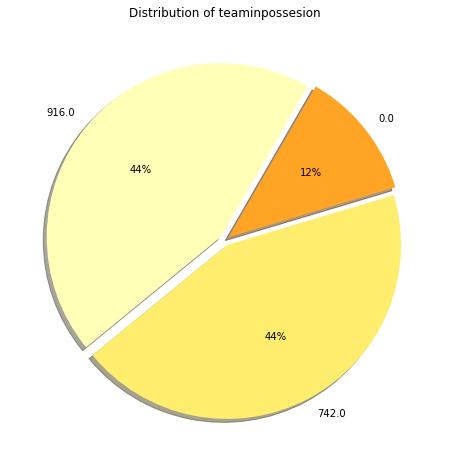

In [22]:
print(game_66445.teaminpossession.value_counts())

colors = sns.color_palette('afmhot_r')

plt.figure(figsize=(8,8))
plt.pie(x = game_66445.teaminpossession.value_counts().values, 
        labels= game_66445.teaminpossession.value_counts().index.to_list(), 
        explode = (0.03,0.03,0.03), autopct='%.0f%%',
       startangle=60, colors=colors,shadow=True)
plt.title('Distribution of teaminpossesion')

Text(0.5, 1.0, 'Team in Possession')

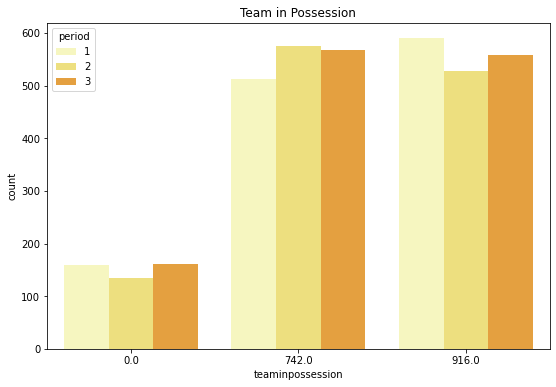

In [23]:

# Let's see which team was in possession for the most time
plt.figure(figsize=(9,6))
colors = sns.color_palette('afmhot_r')
sns.countplot(game_66445.teaminpossession, hue=game_66445.period, palette = colors)
plt.title('Team in Possession')

# Looks like possession for both the teams were balanced during the whole play.

# Current possession

In [24]:
game_66445.currentpossession

# What do these values mean? Maybe we need to see it with a different context

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
        ...  
3782    614.0
3783    614.0
3784    615.0
3785    615.0
3786    615.0
Name: currentpossession, Length: 3787, dtype: float64

In [25]:
game_66445[game_66445.teamid == 742]['currentpossession'].value_counts()

0.0      241
272.0     23
30.0      17
591.0     16
242.0     16
        ... 
113.0      1
409.0      1
410.0      1
412.0      1
109.0      1
Name: currentpossession, Length: 480, dtype: int64

# Expected goal

In [26]:
game_66445.xg  # It is the probability of a goal

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3782    0.0
3783    0.0
3784    0.0
3785    0.0
3786    0.0
Name: xg, Length: 3787, dtype: float64

#### In the broadest sense, expected goals (xG) is a measure that seeks to address the concern that not all shots are created equal. xG considers a variety of factors and then mathematically assigns a value to each shot attempt that represents the probability of that shot becoming a goal.

# Event name

Text(0.5, 1.0, 'Count plot of event names by different teams')

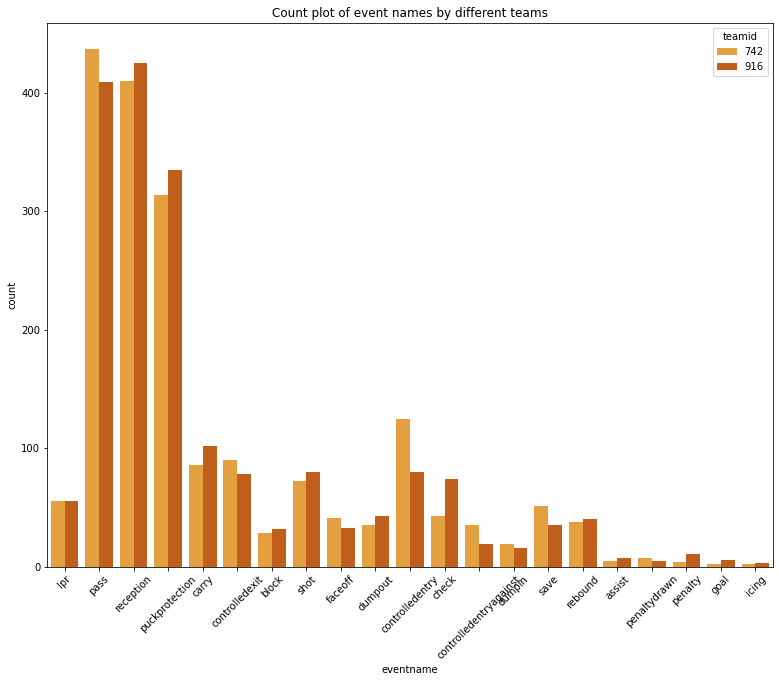

In [27]:
game_66445.eventname.value_counts()

# These are event names for every time stamp performed by both teams

plt.figure(figsize=(13,10))
countplot = sns.countplot(x=game_66445.eventname, orient='v', hue=game_66445.teamid, palette=colors[2:5])
labels = np.array(game_66445.eventname.value_counts().index).tolist()
countplot.set_xticklabels(labels , rotation = 45  )
countplot.set_title('Count plot of event names by different teams')

Text(0.5, 1.0, 'Count plot of event names in different periods')

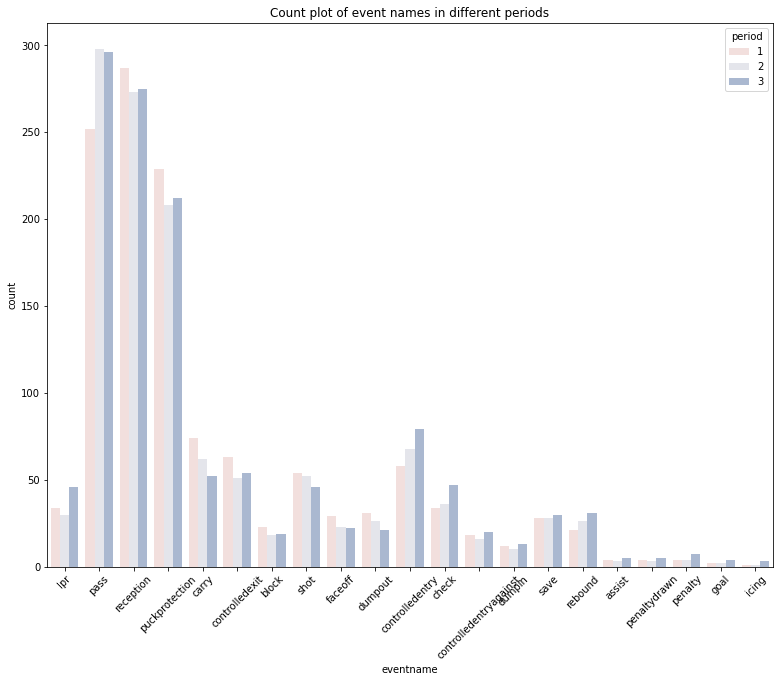

In [28]:
plt.figure(figsize=(13,10))
countplot = sns.countplot(x=game_66445.eventname, orient='v', hue=game_66445.period, 
                          palette=sns.color_palette('vlag_r')[2:], saturation=1)
labels = np.array(game_66445.eventname.value_counts().index).tolist()
countplot.set_xticklabels(labels , rotation = 45  )
countplot.set_title('Count plot of event names in different periods')

# Is home game?

In [29]:
game_66445[game_66445.ishomegame==1].iloc[0]

# We see that for team 742, it is a home game since the 'ishomegame' value is 1.
# And hence it would be away game for team 916. We cannot do much about this feature as it only tells a charactertic of whole 
# game but would be useful in context of ML algorithm.

gameid                                  66445
opposingteamgoalieoniceid            506563.0
opposingteamid                            916
playerid                               358235
teamgoalieoniceid                    940804.0
teamid                                    742
teaminpossession                          0.0
currentpossession                         0.0
xg                                        0.0
compiledgametime                          0.0
eventname                             faceoff
ishomegame                                  1
manpowersituation                evenStrength
opposingteamskatersonicecount               5
outcome                                failed
period                                      1
playerprimaryposition                       F
scoredifferential                           0
teamskatersonicecount                       5
type                                     none
xadjcoord                            0.305008
yadjcoord                         

# Man power situation

In [30]:
game_66445.manpowersituation.value_counts()

# This feature is time dependent and can change at different time stamps. Let's visualize it further.

evenStrength    2574
powerPlay        897
shortHanded      316
Name: manpowersituation, dtype: int64

Text(0.5, 1.0, 'Distribution of man power situation')

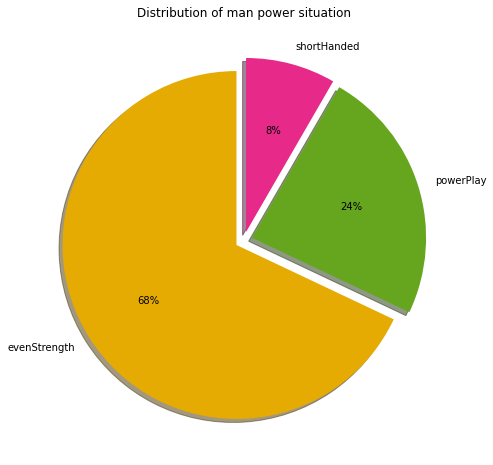

In [31]:
plt.figure(figsize=(8,8))
plt.pie(x = game_66445.manpowersituation.value_counts().values, 
        labels= game_66445.manpowersituation.value_counts().index.to_list(), 
        explode = (0.05,0.05,0.05), autopct='%.0f%%',
       startangle=90, colors=sns.color_palette('Dark2_r')[1:], shadow=True)
plt.title('Distribution of man power situation')

Text(0.5, 1.0, 'Plot representing man power situation in each team')

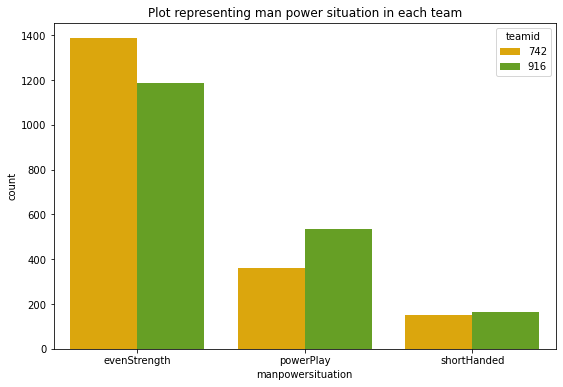

In [32]:
plt.figure(figsize=(9,6))
sns.countplot(game_66445.manpowersituation, hue= game_66445.teamid, 
              palette=sns.color_palette('Dark2_r')[1:], saturation=0.9)
plt.title('Plot representing man power situation in each team')

# Looks like team 916 had more chances of powerplay

Text(0.5, 1.0, 'Plot representing man power situation with team in possession')

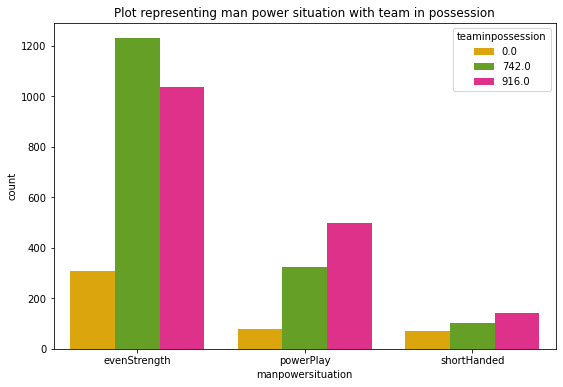

In [33]:
plt.figure(figsize=(9,6))
sns.countplot(game_66445.manpowersituation, hue= game_66445.teaminpossession, 
              palette=sns.color_palette('Dark2_r')[1:], saturation=0.9)
plt.title('Plot representing man power situation with team in possession')

Text(0.5, 1.0, 'Plot representing man power situation in each period')

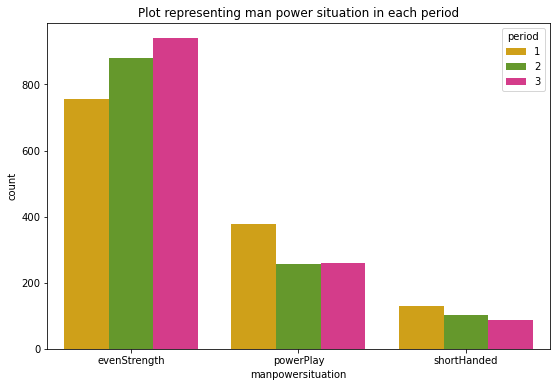

In [34]:
plt.figure(figsize=(9,6))
sns.countplot(game_66445.manpowersituation, hue= game_66445.period, palette=sns.color_palette('Dark2_r')[1:], saturation=0.8)
plt.title('Plot representing man power situation in each period')

In [35]:
game_66445.groupby('manpowersituation').max()

,gameid,opposingteamgoalieoniceid,opposingteamid,playerid,teamgoalieoniceid,teamid,teaminpossession,currentpossession,xg,compiledgametime,...,ishomegame,opposingteamskatersonicecount,outcome,period,playerprimaryposition,scoredifferential,teamskatersonicecount,type,xadjcoord,yadjcoord
manpowersituation,,,,,,,,,,,,,,,,,,,,,
evenStrength,66445,940804.0,916,997285,940804.0,916,916.0,602.0,0.272987,3532.5000,...,1,6,undetermined,3,G,4,6,tripping,99.384415,41.997059
powerPlay,66445,940804.0,916,975429,940804.0,916,916.0,615.0,0.300163,3596.5667,...,1,4,successful,3,G,2,6,stretchoffboards,98.774399,41.997059
shortHanded,66445,940804.0,916,997285,940804.0,916,916.0,614.0,0.521534,3591.7666,...,1,6,successful,3,G,4,4,stretch,96.869720,40.988235


In [36]:
game_66445.groupby('manpowersituation').min()

,gameid,opposingteamgoalieoniceid,opposingteamid,playerid,teamgoalieoniceid,teamid,teaminpossession,currentpossession,xg,compiledgametime,...,ishomegame,opposingteamskatersonicecount,outcome,period,playerprimaryposition,scoredifferential,teamskatersonicecount,type,xadjcoord,yadjcoord
manpowersituation,,,,,,,,,,,,,,,,,,,,,
evenStrength,66445,0.0,742,39604,0.0,742,0.0,0.0,0.0,0.00000,...,0,5,failed,1,D,-4,5,1on0,-99.887360,-41.994118
powerPlay,66445,506563.0,742,47709,0.0,742,0.0,0.0,0.0,142.33333,...,0,3,failed,1,D,-4,5,1on1,-98.881485,-41.491173
shortHanded,66445,0.0,742,39604,506563.0,742,0.0,0.0,0.0,142.33333,...,0,5,failed,1,D,-2,3,1on1,-98.774399,-41.997059


# Opposing team skaters on ice count

In [37]:
game_66445.opposingteamskatersonicecount.value_counts()

5    2848
4     803
3      94
6      42
Name: opposingteamskatersonicecount, dtype: int64

Text(0.5, 1.0, 'Distribution of opposing team skaters on ice')

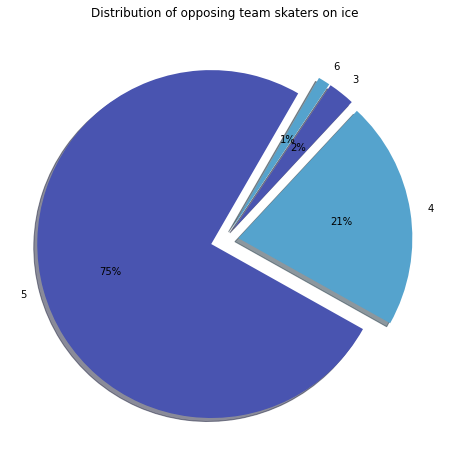

In [38]:
plt.figure(figsize=(8,8))
plt.pie(x = game_66445.opposingteamskatersonicecount.value_counts().values, 
        labels= game_66445.opposingteamskatersonicecount.value_counts().index.to_list(), 
        explode = (0.08,)*4, autopct='%.0f%%',
       startangle=60, colors=sns.color_palette('icefire_r')[4:], shadow=True)
plt.title('Distribution of opposing team skaters on ice')

Text(0.5, 1.0, 'Plot representing opposing team skaters in each team')

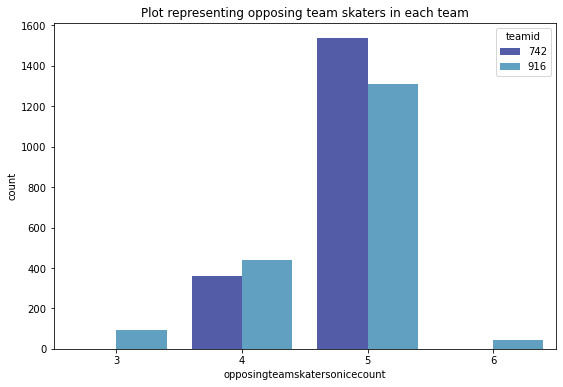

In [39]:
plt.figure(figsize=(9,6))
sns.countplot(game_66445.opposingteamskatersonicecount, hue= game_66445.teamid, 
              palette=sns.color_palette('icefire_r')[4:], saturation=0.8)
plt.title('Plot representing opposing team skaters in each team')

Text(0.5, 1.0, 'Plot representing opposing team skaters in each period')

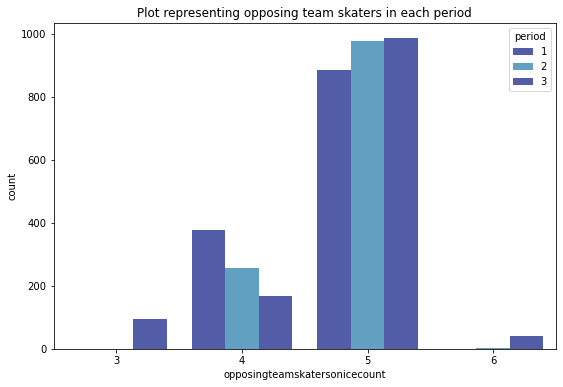

In [40]:
plt.figure(figsize=(9,6))
sns.countplot(game_66445.opposingteamskatersonicecount, hue= game_66445.period, 
              palette=sns.color_palette('icefire_r')[4:], saturation=0.8)
plt.title('Plot representing opposing team skaters in each period')

Text(0.5, 1.0, 'Plot representing opposing team skaters and their xg probability')

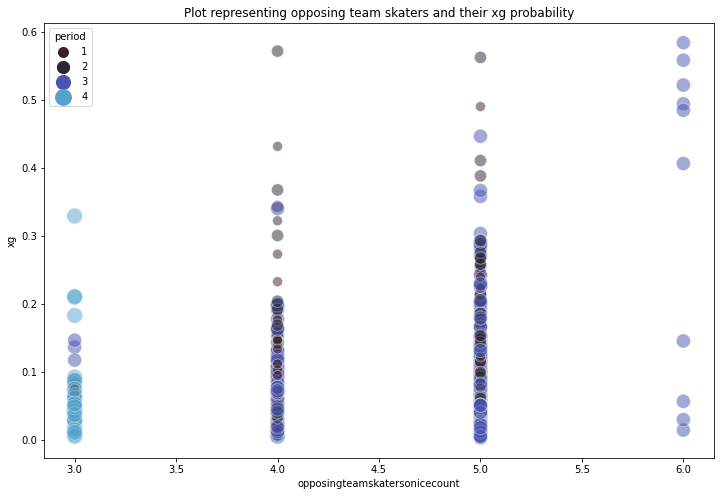

In [41]:
plt.figure(figsize=(12,8))
sns.scatterplot(x = df.opposingteamskatersonicecount, y = df.xg, hue=df.period, size=df.period, sizes=(100,250), 
                alpha =0.5, palette=sns.color_palette('icefire_r')[2:6])
plt.title('Plot representing opposing team skaters and their xg probability')

Text(0.5, 1.0, 'Plot representing opposing team skaters and compiled game time')

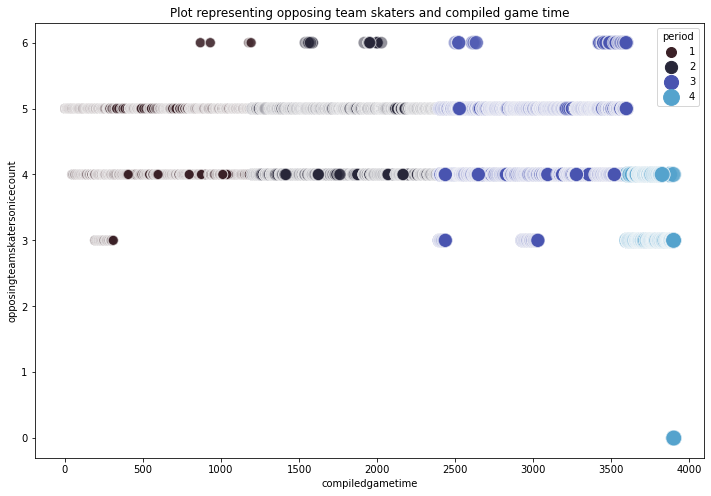

In [42]:
plt.figure(figsize=(12,8))
sns.scatterplot(x = df.compiledgametime, y = df.opposingteamskatersonicecount, hue=df.period,size=df.period, sizes=(100,250), 
                alpha =0.5, palette=sns.color_palette('icefire_r')[2:6])
plt.title('Plot representing opposing team skaters and compiled game time')

# Outcome

In [43]:
game_66445.outcome.value_counts()

successful      2893
failed           893
undetermined       1
Name: outcome, dtype: int64

Text(0.5, 1.0, 'Distribution of opposing team skaters on ice')

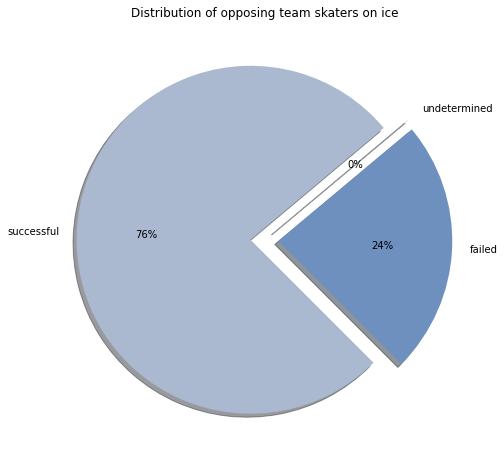

In [44]:
plt.figure(figsize=(8,8))
plt.pie(x = game_66445.outcome.value_counts().values, 
        labels= game_66445.outcome.value_counts().index.to_list(), 
        explode = (0.08,)*3, autopct='%.0f%%',
       startangle=40, colors=sns.color_palette('vlag_r')[4:], shadow=True)
plt.title('Distribution of opposing team skaters on ice')

Text(0.5, 1.0, 'Plot representing outcome in each team')

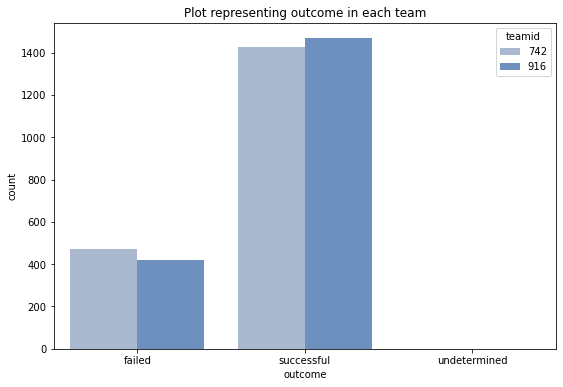

In [45]:
plt.figure(figsize=(9,6))
sns.countplot(game_66445.outcome, hue= game_66445.teamid, 
              palette=sns.color_palette('vlag_r')[4:], saturation=1)
plt.title('Plot representing outcome in each team')

Text(0.5, 1.0, 'Plot representing outcome in each period')

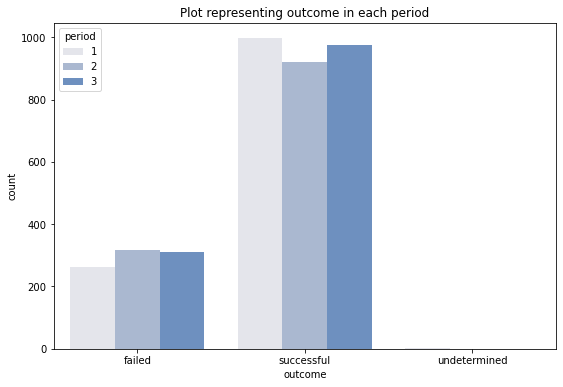

In [46]:
plt.figure(figsize=(9,6))
sns.countplot(game_66445.outcome, hue= game_66445.period, 
              palette=sns.color_palette('vlag_r')[3:], saturation=1)
plt.title('Plot representing outcome in each period')

# Player primary position

In [47]:
game_66445.playerprimaryposition.value_counts()

F    2278
D    1357
G     152
Name: playerprimaryposition, dtype: int64

Text(0.5, 1.0, 'Distribution of player primary position')

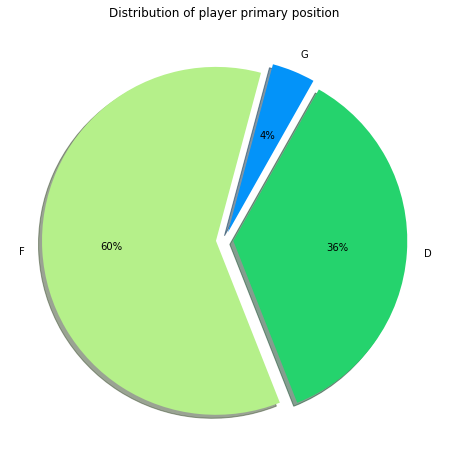

In [48]:
plt.figure(figsize=(8,8))
plt.pie(x = game_66445.playerprimaryposition.value_counts().values, 
        labels= game_66445.playerprimaryposition.value_counts().index.to_list(), 
        explode = (0.05,)*3, autopct='%.0f%%',
       startangle=75, colors=sns.color_palette('terrain_r')[3:], shadow=True)
plt.title('Distribution of player primary position')

Text(0.5, 1.0, 'Plot representing player primary position in each team')

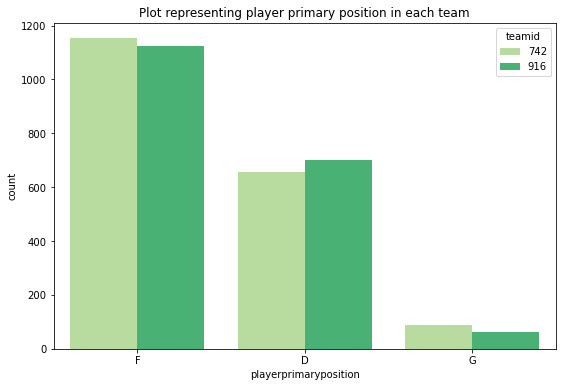

In [49]:
plt.figure(figsize=(9,6))
sns.countplot(game_66445.playerprimaryposition, hue= game_66445.teamid, 
              palette=sns.color_palette('terrain_r')[3:], saturation=0.6)
plt.title('Plot representing player primary position in each team')

Text(0.5, 1.0, 'Plot representing player primary position in each period')

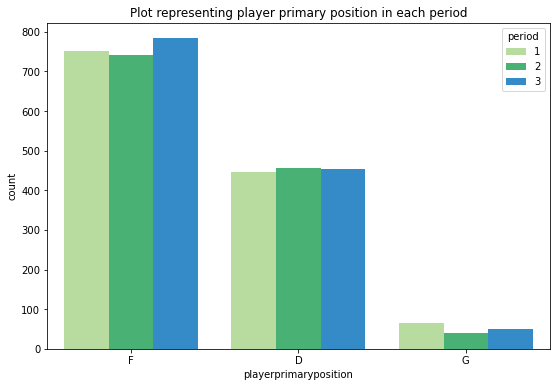

In [50]:
plt.figure(figsize=(9,6))
sns.countplot(game_66445.playerprimaryposition, hue= game_66445.period, 
              palette=sns.color_palette('terrain_r')[3:], saturation=0.6)
plt.title('Plot representing player primary position in each period')

# Score differential

In [51]:
game_66445.scoredifferential.value_counts()

 2    1269
-2    1133
-1     462
 1     393
 0     183
-3     135
 3     120
-4      66
 4      26
Name: scoredifferential, dtype: int64

Text(0.5, 1.0, 'Distribution of opposing team skaters on ice')

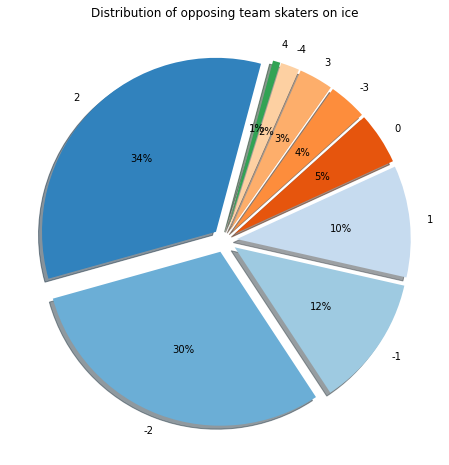

In [52]:
plt.figure(figsize=(8,8))
plt.pie(x = game_66445.scoredifferential.value_counts().values, 
        labels= game_66445.scoredifferential.value_counts().index.to_list(), 
        explode = (0.07,)*9, autopct='%.0f%%',
       startangle=75, colors=sns.color_palette('tab20c'), shadow=True)
plt.title('Distribution of opposing team skaters on ice')

Text(0.5, 1.0, 'Plot representing score differential in each team')

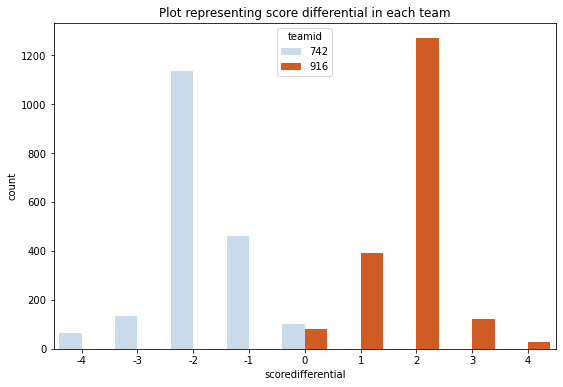

In [53]:
plt.figure(figsize=(9,6))
sns.countplot(game_66445.scoredifferential, hue= game_66445.teamid, 
              palette=sns.color_palette('tab20c')[3:], saturation=0.8)
plt.title('Plot representing score differential in each team')

Text(0.5, 1.0, 'Plot representing score differential in each team')

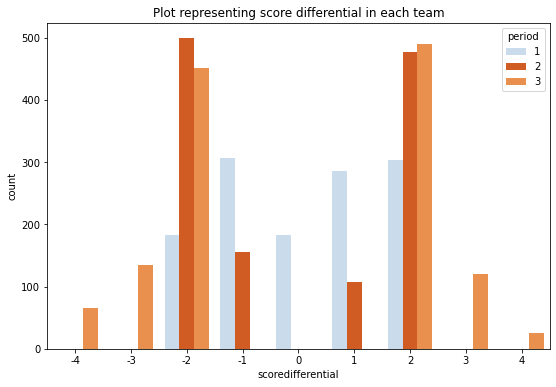

In [54]:
plt.figure(figsize=(9,6))
sns.countplot(game_66445.scoredifferential, hue= game_66445.period, 
              palette=sns.color_palette('tab20c')[3:], saturation=0.8)
plt.title('Plot representing score differential in each team')

# Type

Text(0, 0.5, 'Count')

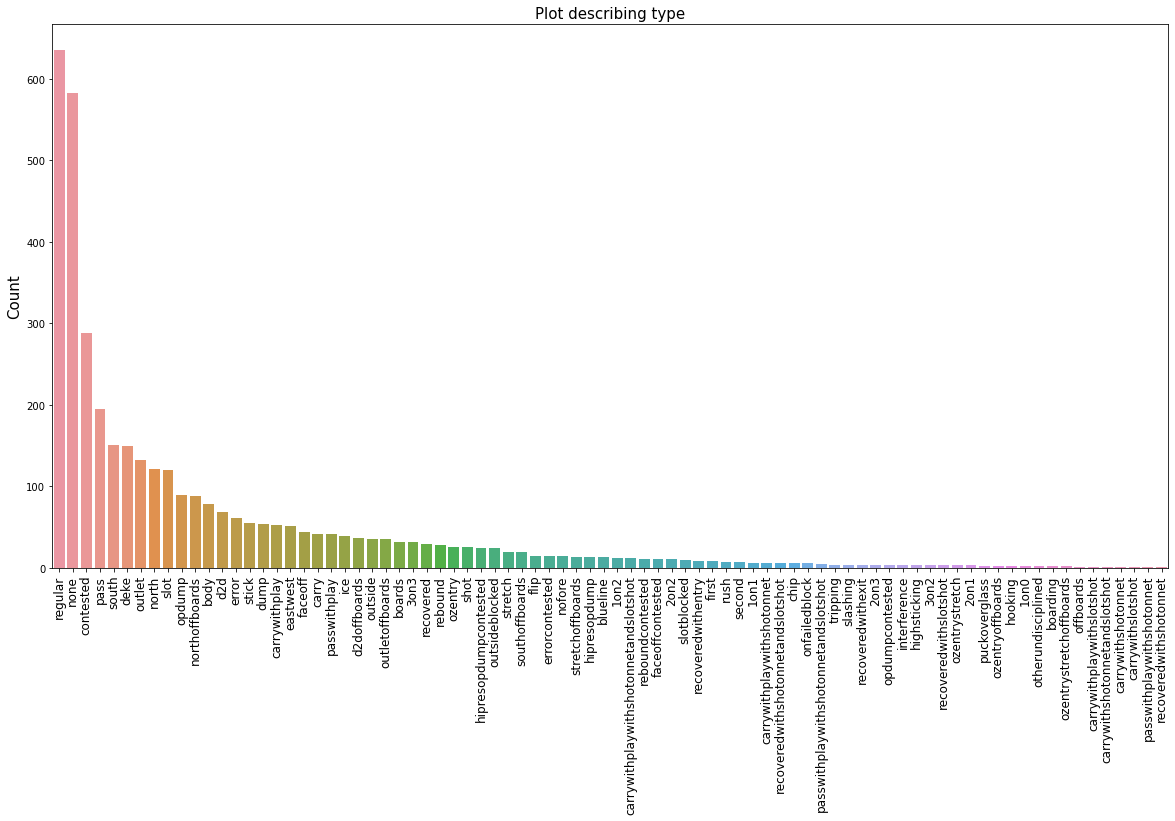

In [55]:
plt.figure(figsize=(20,10))

barplot = sns.barplot(x = game_66445.type.value_counts().index.to_list(), y = game_66445.type.value_counts().values)
labels = np.array(game_66445.type.value_counts().index).tolist()
barplot.set_xticklabels(labels , rotation = 90 , fontdict={'fontsize': 12,'horizontalalignment': 'center'} )
barplot.set_title('Plot describing type',fontdict={'fontsize': 15})
barplot.set_ylabel('Count',fontdict={'fontsize': 15})

# Team skaters on ice count

In [56]:
game_66445.teamskatersonicecount.value_counts()

5    3397
4     291
6      74
3      25
Name: teamskatersonicecount, dtype: int64

Text(0.5, 1.0, 'Distribution of team skaters on ice')

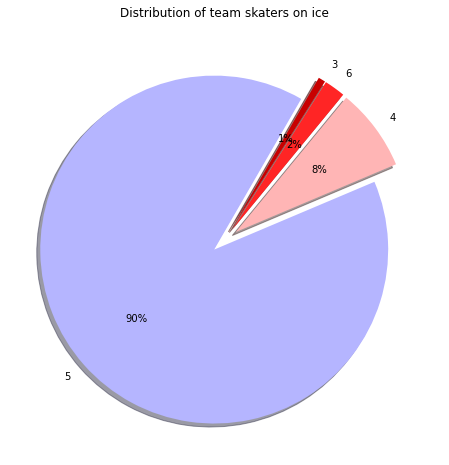

In [57]:
plt.figure(figsize=(8,8))
plt.pie(x = game_66445.teamskatersonicecount.value_counts().values, 
        labels= game_66445.teamskatersonicecount.value_counts().index.to_list(), 
        explode = (0.08,)*4, autopct='%.0f%%',
       startangle=60, colors=sns.color_palette('seismic')[2:], shadow=True)
plt.title('Distribution of team skaters on ice')

Text(0.5, 1.0, 'Plot representing team skaters in each team')

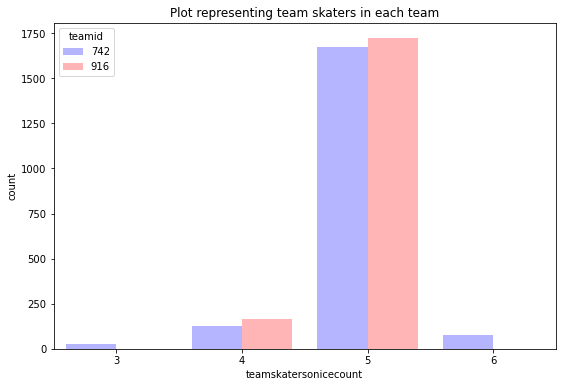

In [58]:
plt.figure(figsize=(9,6))
sns.countplot(game_66445.teamskatersonicecount, hue= game_66445.teamid, 
              palette=sns.color_palette('seismic')[2:], saturation=1)
plt.title('Plot representing team skaters in each team')

Text(0.5, 1.0, 'Plot representing team skaters in each period')

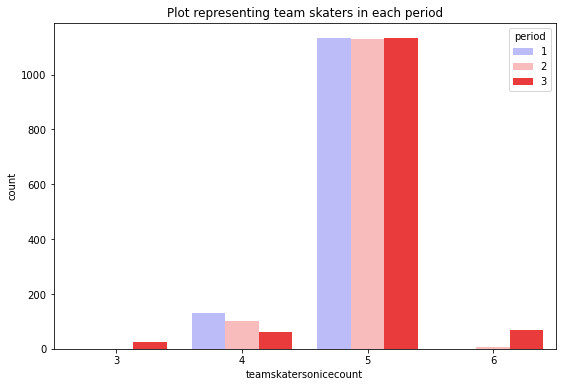

In [59]:
plt.figure(figsize=(9,6))
sns.countplot(game_66445.teamskatersonicecount, hue= game_66445.period, 
              palette=sns.color_palette('seismic')[2:], saturation=0.8)
plt.title('Plot representing team skaters in each period')

Text(0.5, 1.0, 'Plot representing team skaters in each period and their xg probability')

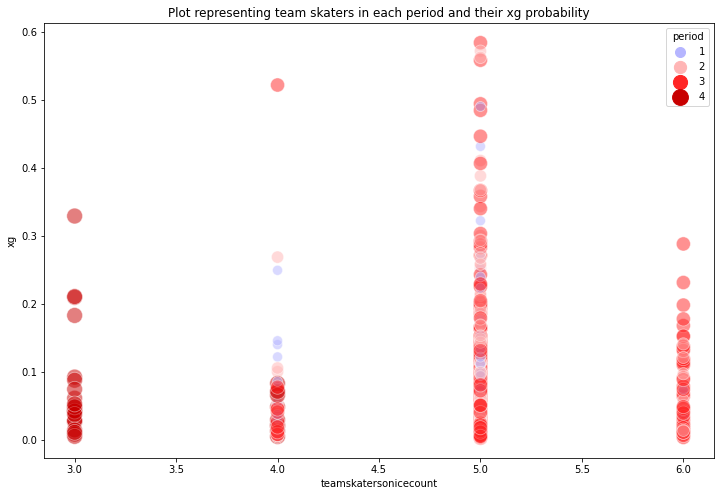

In [60]:
plt.figure(figsize=(12,8))
sns.scatterplot(x = df.teamskatersonicecount, y = df.xg, hue=df.period,size=df.period, sizes=(100,250), 
                alpha =0.5, palette=sns.color_palette('seismic')[2:6])
plt.title('Plot representing team skaters in each period and their xg probability')

Text(0.5, 1.0, 'Plot representing team skaters in each period and compiled game time')

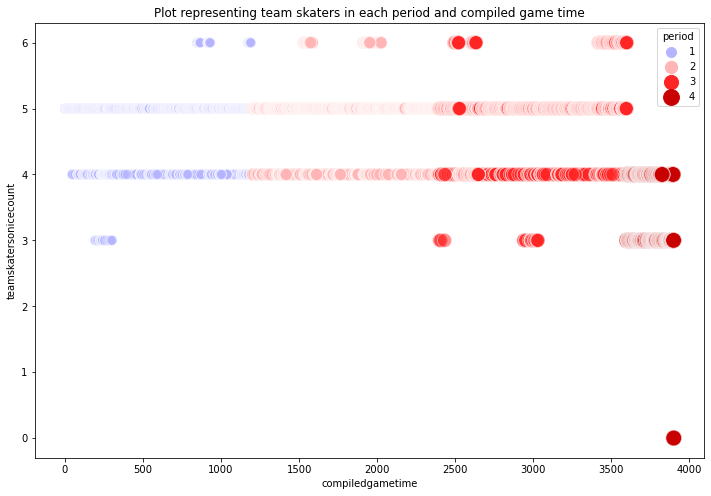

In [61]:


plt.figure(figsize=(12,8))
sns.scatterplot(x = df.compiledgametime, y = df.teamskatersonicecount, hue=df.period,size=df.period, sizes=(100,250), 
                alpha =0.5, palette=sns.color_palette('seismic')[2:6])
plt.title('Plot representing team skaters in each period and compiled game time')

# X and Y coordinate

<AxesSubplot:xlabel='xadjcoord', ylabel='yadjcoord'>

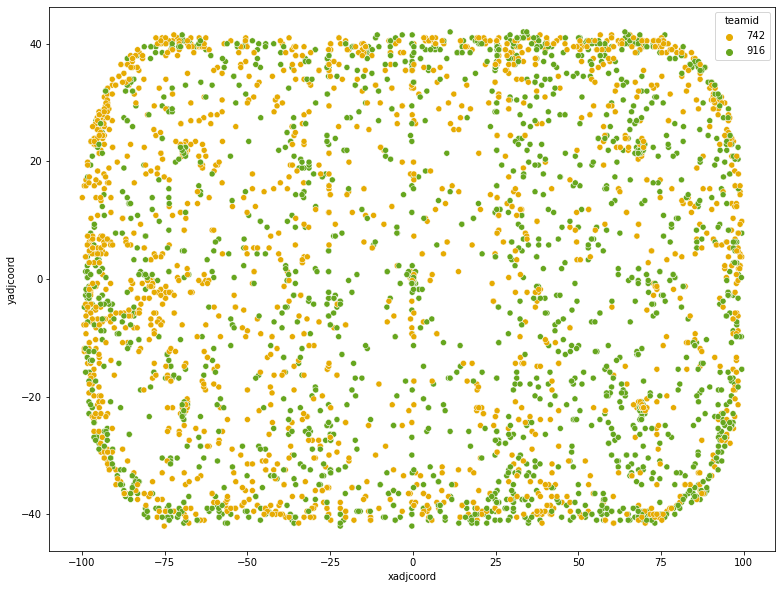

In [62]:
plt.figure(figsize=(13,10))
sns.scatterplot(x = game_66445.xadjcoord, 
                y = game_66445.yadjcoord, 
                hue=game_66445.teamid, 
                palette= sns.color_palette('Dark2_r')[1:3])

In [63]:
# Function to encode categorical variables using label encoder

def encode_cat_var(df, col):
    
    return LabelEncoder().fit_transform(df.loc[:,col])
     

In [64]:
for col in game_66445.select_dtypes(include='object').columns:
    game_66445.loc[:,col] = encode_cat_var(game_66445, col)

In [65]:
game_66445.head()

,gameid,opposingteamgoalieoniceid,opposingteamid,playerid,teamgoalieoniceid,teamid,teaminpossession,currentpossession,xg,compiledgametime,...,manpowersituation,opposingteamskatersonicecount,outcome,period,playerprimaryposition,scoredifferential,teamskatersonicecount,type,xadjcoord,yadjcoord
0,66445,506563.0,916,358235,940804.0,742,0.0,0.0,0.0,0.000000,...,0,5,0,1,1,0,5,40,0.305008,-0.252941
1,66445,940804.0,742,586302,506563.0,916,0.0,0.0,0.0,0.000000,...,0,5,1,1,1,0,5,64,-0.305008,0.252941
2,66445,506563.0,916,358235,940804.0,742,0.0,0.0,0.0,0.033333,...,0,5,0,1,1,0,5,21,-0.197929,0.752941
3,66445,940804.0,742,689086,506563.0,916,916.0,0.0,0.0,0.100000,...,0,5,1,1,0,0,5,29,-7.849129,-4.776470
4,66445,940804.0,742,689086,506563.0,916,916.0,0.0,0.0,0.166667,...,0,5,1,1,0,0,5,76,-6.843246,-3.267647


In [66]:
game_66445.loc[:,'opposingteamgoalieoniceid'] = game_66445.opposingteamgoalieoniceid.apply(lambda x: 1 if x == 506563.0 else 2)

In [67]:
game_66445.loc[:,'teamgoalieoniceid'] = game_66445.teamgoalieoniceid.apply(lambda x : 1 if x == 506563.0 else 2)

In [68]:
game_66445.loc[:,'playerid'] = encode_cat_var(game_66445, 'playerid')

In [69]:
game_66445.gameid = 1

<AxesSubplot:>

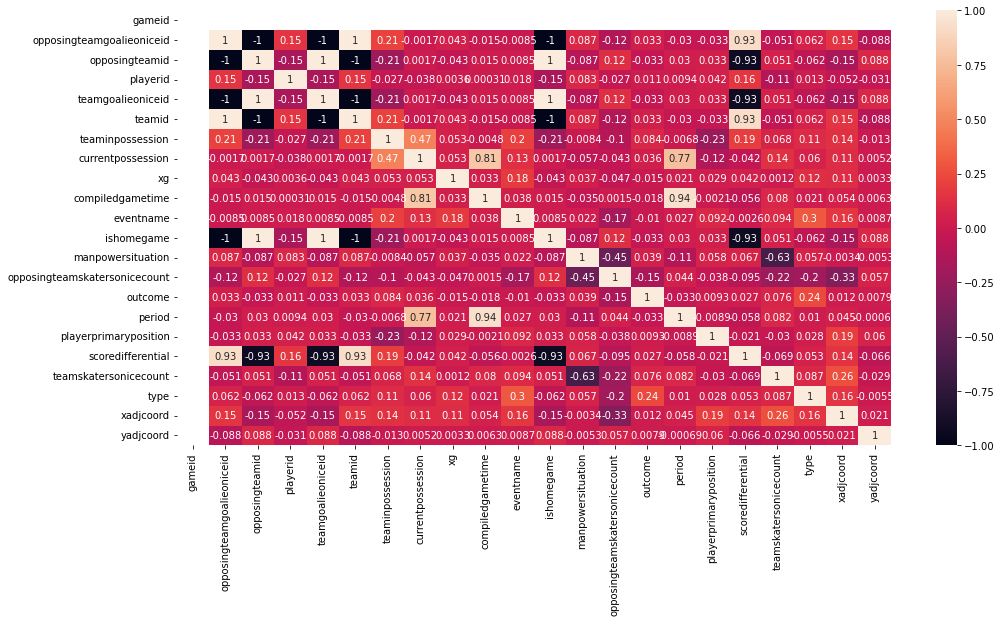

In [70]:
# Looking at the correlation matrix for one game

plt.figure(figsize=(16,8))
sns.heatmap(game_66445.corr(),annot=True)

#### Since we see that, variables 'teamid', 'opposingteamid' and 'ishomegame' are highly correlated and it makes sense also since they are all telling the same information. If we could encode all this information in one variable, it would be fun

In [71]:
game_66445.drop(['opposingteamid', 'teamid'], axis=1, inplace=True)

In [72]:
y_train = game_66445.pop('outcome')

In [73]:
data  = StandardScaler().fit_transform(game_66445)
data.shape

(3787, 19)

In [74]:
game_66445_scaled = pd.DataFrame(data= data , columns= game_66445.columns, index=game_66445.index)

<AxesSubplot:>

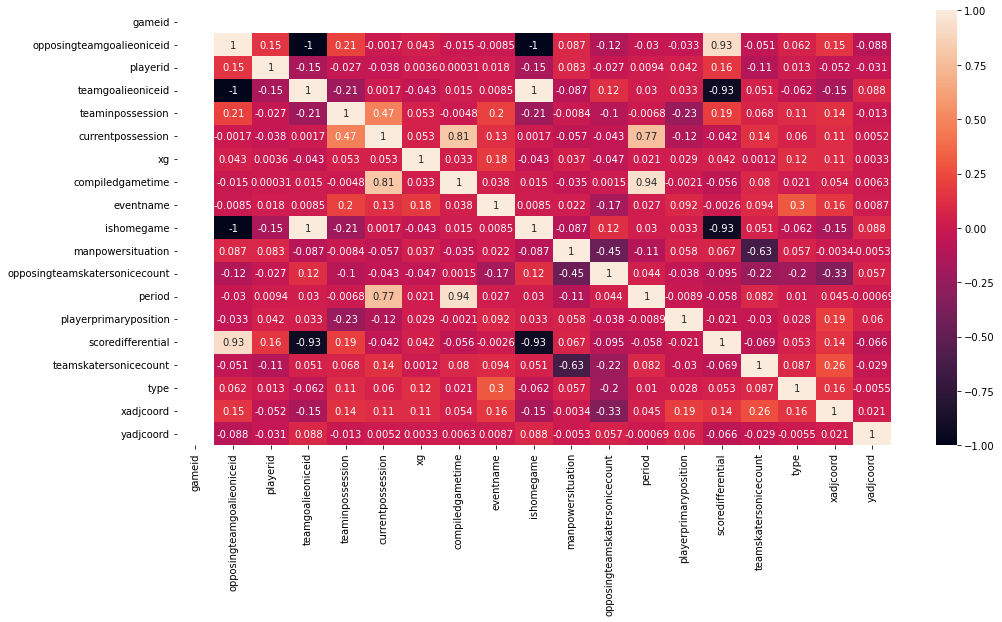

In [75]:
plt.figure(figsize=(16,8))
sns.heatmap(game_66445_scaled.corr(),annot=True)

# Preparing the same configuration for whole dataset

In [76]:
df.fillna(0,axis=0, inplace=True )

In [77]:
# There are 46 values with 'undetermined' outcome and we will remove them as they cause noise while training the model

df.drop(index = df[df.outcome == 'undetermined'].index, axis=0, inplace=True)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75995 entries, 0 to 76040
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   gameid                         75995 non-null  int64  
 1   opposingteamgoalieoniceid      75995 non-null  float64
 2   opposingteamid                 75995 non-null  int64  
 3   playerid                       75995 non-null  int64  
 4   teamgoalieoniceid              75995 non-null  float64
 5   teamid                         75995 non-null  int64  
 6   teaminpossession               75995 non-null  float64
 7   currentpossession              75995 non-null  float64
 8   xg                             75995 non-null  float64
 9   compiledgametime               75995 non-null  float64
 10  eventname                      75995 non-null  object 
 11  ishomegame                     75995 non-null  int64  
 12  manpowersituation              75995 non-null 

In [79]:
# Creating a dictionary that shows the game id with its corresponding teams and encoded values

gameid_teams_dict = {}
for key, gameid in enumerate(df.gameid.unique()):
    gameid_teams_dict[gameid] = (tuple(df[df.gameid == gameid][['teamid','opposingteamid']].iloc[0].unique()),key)
    
    
gameid_teams_dict

{66445: ((742, 916), 0),
 83522: ((907, 824), 1),
 73649: ((916, 915), 2),
 63799: ((916, 650), 3),
 88237: ((907, 564), 4),
 60432: ((915, 729), 5),
 86583: ((787, 579), 6),
 71102: ((824, 583), 7),
 81893: ((787, 771), 8),
 84953: ((807, 915), 9),
 80711: ((729, 650), 10),
 89409: ((896, 771), 11),
 77265: ((824, 771), 12),
 73282: ((807, 896), 13),
 78204: ((583, 579), 14),
 87892: ((787, 583), 15),
 75425: ((564, 729), 16),
 78500: ((579, 807), 17),
 87080: ((896, 742), 18),
 65884: ((742, 907), 19)}

In [80]:
df.columns

Index(['gameid', 'opposingteamgoalieoniceid', 'opposingteamid', 'playerid',
       'teamgoalieoniceid', 'teamid', 'teaminpossession', 'currentpossession',
       'xg', 'compiledgametime', 'eventname', 'ishomegame',
       'manpowersituation', 'opposingteamskatersonicecount', 'outcome',
       'period', 'playerprimaryposition', 'scoredifferential',
       'teamskatersonicecount', 'type', 'xadjcoord', 'yadjcoord'],
      dtype='object')

In [81]:
cat_columns = ['opposingteamgoalieoniceid', 'opposingteamid', 'playerid',
       'teamgoalieoniceid', 'teamid', 'teaminpossession', 'currentpossession','eventname', 'ishomegame',
       'manpowersituation', 'outcome', 'playerprimaryposition', 'type' ]

In [82]:
for col in cat_columns:
    df.loc[:,col] = encode_cat_var(df,col)

<AxesSubplot:>

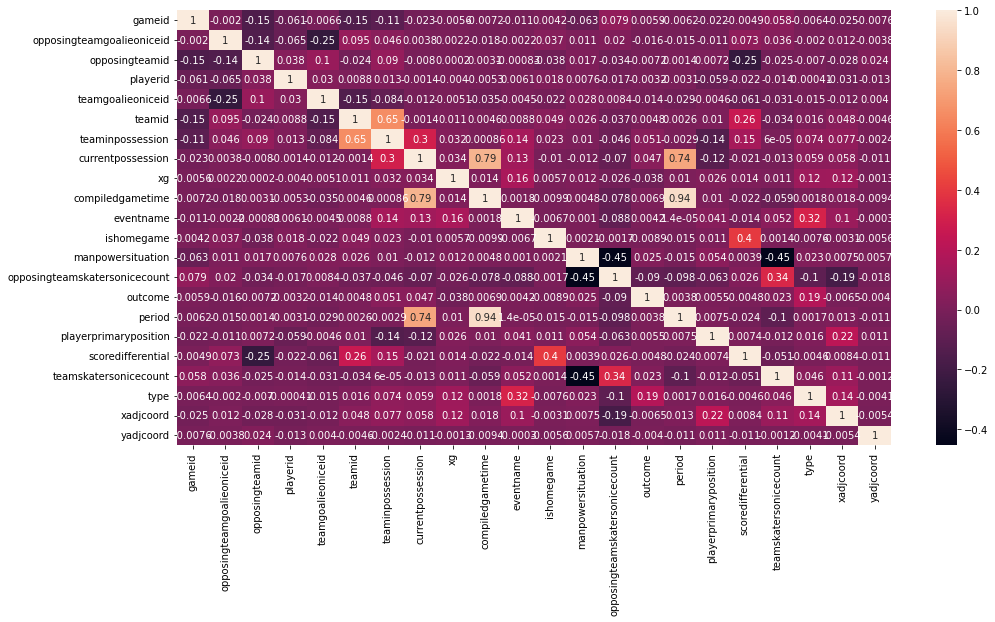

In [83]:
plt.figure(figsize=(16,8))
sns.heatmap(df.corr(),annot=True)

In [84]:
df.head()

,gameid,opposingteamgoalieoniceid,opposingteamid,playerid,teamgoalieoniceid,teamid,teaminpossession,currentpossession,xg,compiledgametime,...,manpowersituation,opposingteamskatersonicecount,outcome,period,playerprimaryposition,scoredifferential,teamskatersonicecount,type,xadjcoord,yadjcoord
0,66445,13,13,128,24,5,0,0,0.0,0.000000,...,0,5,0,1,1,0,5,49,0.305008,-0.252941
1,66445,24,5,215,13,13,0,0,0.0,0.000000,...,0,5,1,1,1,0,5,77,-0.305008,0.252941
2,66445,13,13,128,24,5,0,0,0.0,0.033333,...,0,5,0,1,1,0,5,23,-0.197929,0.752941
3,66445,24,5,252,13,13,14,0,0.0,0.100000,...,0,5,1,1,0,0,5,33,-7.849129,-4.776470
4,66445,24,5,252,13,13,14,0,0.0,0.166667,...,0,5,1,1,0,0,5,91,-6.843246,-3.267647


In [85]:
# Mapping each game id with a unique number to make analysis easier

game_dict = {game:key for key,game in enumerate(df.gameid.unique())}
game_dict

{66445: 0,
 83522: 1,
 73649: 2,
 63799: 3,
 88237: 4,
 60432: 5,
 86583: 6,
 71102: 7,
 81893: 8,
 84953: 9,
 80711: 10,
 89409: 11,
 77265: 12,
 73282: 13,
 78204: 14,
 87892: 15,
 75425: 16,
 78500: 17,
 87080: 18,
 65884: 19}

In [86]:
df.loc[:,'gameid'] = df.gameid.apply(lambda x : game_dict[x])

In [87]:
df.head()

,gameid,opposingteamgoalieoniceid,opposingteamid,playerid,teamgoalieoniceid,teamid,teaminpossession,currentpossession,xg,compiledgametime,...,manpowersituation,opposingteamskatersonicecount,outcome,period,playerprimaryposition,scoredifferential,teamskatersonicecount,type,xadjcoord,yadjcoord
0,0,13,13,128,24,5,0,0,0.0,0.000000,...,0,5,0,1,1,0,5,49,0.305008,-0.252941
1,0,24,5,215,13,13,0,0,0.0,0.000000,...,0,5,1,1,1,0,5,77,-0.305008,0.252941
2,0,13,13,128,24,5,0,0,0.0,0.033333,...,0,5,0,1,1,0,5,23,-0.197929,0.752941
3,0,24,5,252,13,13,14,0,0.0,0.100000,...,0,5,1,1,0,0,5,33,-7.849129,-4.776470
4,0,24,5,252,13,13,14,0,0.0,0.166667,...,0,5,1,1,0,0,5,91,-6.843246,-3.267647


In [88]:
# function to separate training, validation and test games

def data_split_scale(df, test_game = 10, val_game=12):
    
    # creating games list to select desired game 
    games = list(range(20))
    
    # choosing test game to evaluate our model on
    test_data = df.loc[df.gameid == test_game,:]
    games.remove(test_game)
    
    # choosing validation data to use in our model
    val_data = df.loc[df.gameid == val_game, :]
    games.remove(val_game)
    
    # creating train data to feed it in our model
    train_data = df.loc[df.gameid.isin(games),:]
    
    # Seperating all the labels
    y_train = train_data.pop('outcome')
    y_val = val_data.pop('outcome')
    y_test = test_data.pop('outcome')
    
    # Creating scaler object
    scaler = MinMaxScaler().fit(train_data)
    
    # Scaling all the datasets
    scaled_train = pd.DataFrame(data = scaler.transform(train_data), columns=train_data.columns)
    
    scaled_test = pd.DataFrame(data = scaler.transform(test_data), columns=test_data.columns)
    
    scaled_val = pd.DataFrame(data = scaler.transform(val_data), columns=val_data.columns)
    
    
    return scaled_train, y_train, scaled_val, y_val, scaled_test, y_test
    

In [89]:
X_train, y_train, X_val, y_val, X_test, y_test  = data_split_scale(df,test_game=6, val_game=7)

In [90]:
games = list(range(20))
games

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [91]:
# Checking the shape of train/val/test sets

print(f"Train data shape:{ X_train.shape}") 
print(f"Train data label: {y_train.shape}\n") 
print(f"Validation data shape: {X_val.shape}")
print(f"Validation data label: {y_val.shape}\n") 
print(f"Test data shape: {X_test.shape}")
print(f"Test data label: {y_test.shape}")

Train data shape:(68479, 21)
Train data label: (68479,)

Validation data shape: (3872, 21)
Validation data label: (3872,)

Test data shape: (3644, 21)
Test data label: (3644,)


In [92]:
# Since we are not interested in the compiled game time and game id, we can drop it 

X_train.set_index('compiledgametime', inplace=True)
X_val.set_index('compiledgametime', inplace=True)
X_test.set_index('compiledgametime', inplace=True)

for data in [X_train, X_val, X_test]:
    data.drop('gameid', inplace=True, axis=1)

# Network Architecture

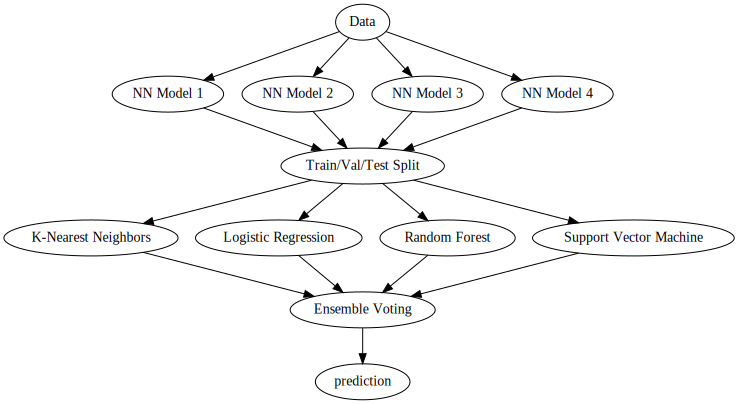

In [93]:
ensemble_graph = graphviz.Digraph()

#first layer
ensemble_graph.edge('Data', 'NN Model 1')
ensemble_graph.edge('Data', 'NN Model 2')
ensemble_graph.edge('Data', 'NN Model 3')
ensemble_graph.edge('Data', 'NN Model 4')

#second layer
ensemble_graph.edge('NN Model 1', 'Train/Val/Test Split')
ensemble_graph.edge('NN Model 2', 'Train/Val/Test Split')
ensemble_graph.edge('NN Model 3', 'Train/Val/Test Split')
ensemble_graph.edge('NN Model 4', 'Train/Val/Test Split')

# Third Layer
ensemble_graph.edge('Train/Val/Test Split', 'K-Nearest Neighbors')
ensemble_graph.edge('Train/Val/Test Split', 'Logistic Regression')
ensemble_graph.edge('Train/Val/Test Split', 'Random Forest')
ensemble_graph.edge('Train/Val/Test Split', 'Support Vector Machine')

# Fourth layer
ensemble_graph.edge('K-Nearest Neighbors', 'Ensemble Voting' )
ensemble_graph.edge('Logistic Regression', 'Ensemble Voting' )
ensemble_graph.edge('Random Forest', 'Ensemble Voting' )
ensemble_graph.edge('Support Vector Machine', 'Ensemble Voting' )

#Final layer
ensemble_graph.edge('Ensemble Voting', 'prediction')

ensemble_graph

## Setting up neural network

In [101]:
# Activation function for hidden layers
leaky_relu = LeakyReLU(alpha=0.2)


# Residual block to train the model
def residual_block(layer, nodes):
    
    layer = Dense(nodes)(layer)
    new = Dense(nodes)(layer)
    new = BatchNormalization(momentum= 0.85)(new)
    new = Activation(activation=leaky_relu)(new)
    new = Dense(nodes)(new)
    # Add layer to create skip connection
    new = Add()([layer, new])
    return new

# General neural network building block
def build_Network(input_shape, layers, nodes):
    
    x_in = Input(shape=input_shape)
    x = Dense(nodes, activation='relu')(x_in)
    for i in range(layers-1):
        # Using fully connected dense layer with L2 regularization
        x = Dense(nodes,kernel_regularizer= L2(l2=0.0001) )(x)
        x = BatchNormalization(momentum= 0.8)(x)
        x = Activation(activation='relu')(x)
        if i%2: # Adding dropout and residual blocks after every two layers
            x = Dropout(0.5)(x)
            x = residual_block(x, 128)
    
    # Adding two more residual blocks
    b = residual_block(x, 128)
    a = residual_block(b,128)
    a = Dropout(0.5)(a)
    a = Dense(128, activation= leaky_relu)(a)
    
    a = Flatten()(a)

    a = Dense(1, activation='sigmoid')(a)
    
    # Finishing the model
    model = Model(inputs=x_in, outputs=a)
    
    # Using adam optimizer, binary loss and accuracy as metrics and compilation
    model.compile(loss= 'binary_crossentropy', optimizer = Adam(), metrics=['accuracy'])
    
    return model

## Neural Network Ensemble

In [102]:
def neural_ensemble_model( batch_size, epochs):
    
    
    # loop to go through each games and make a pair of test and valid games
    for i in range(0,len(games),2):
        
        print('New ensemble')
        
        #partition the data based over the loop
        X_train, y_train, X_val, y_val, X_test, y_test  = data_split_scale(df,test_game=i, val_game=i+1)
        
        print('Training models')
        
        input_shape = X_train.shape[1]
        
        model1 = build_Network(input_shape=input_shape, layers=6, nodes=200)
        history1 = model1.fit(x = X_train, y = y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size= batch_size, verbose= 0)
        score1 = model1.evaluate(X_test, y_test, verbose=0)
        
        clear_session()
        
        model2 = build_Network(input_shape=input_shape, layers=10, nodes=256)
        history2 = model2.fit(x = X_train, y = y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size= batch_size, verbose= 0)
        score2 = model2.evaluate(X_test, y_test, verbose=0)
        
        clear_session()
        
        model3 = build_Network(input_shape=input_shape, layers=8, nodes=256)
        history3 = model3.fit(x = X_train, y = y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size= batch_size, verbose= 0)
        score3 = model3.evaluate(X_test, y_test, verbose=0)
        
        clear_session()
        
        model4 = build_Network(input_shape=input_shape, layers=8, nodes=256)
        history4 = model4.fit(x = X_train, y = y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size= batch_size, verbose= 0)
        score4 = model4.evaluate(X_test, y_test, verbose=0)
        
        clear_session()
        
        scores = [score1[1], score2[1], score3[1], score4[1]]
        
        mean_score = np.mean(scores)
        print(f'Ensemble Score: {mean_score}')
                
        
        

In [99]:
batch_size = 1000
epochs = 80

neural_ensemble_model(batch_size=batch_size, epochs = epochs )

New ensemble
Training models
Ensemble Score: 0.8439646065235138
New ensemble
Training models
Ensemble Score: 0.8259641975164413
New ensemble
Training models
Ensemble Score: 0.8362645506858826
New ensemble
Training models
Ensemble Score: 0.8576426953077316
New ensemble
Training models
Ensemble Score: 0.8497007489204407
New ensemble
Training models
Ensemble Score: 0.8205757588148117
New ensemble
Training models
Ensemble Score: 0.8517102748155594
New ensemble
Training models
Ensemble Score: 0.8280484825372696
New ensemble
Training models
Ensemble Score: 0.8398282527923584
New ensemble
Training models
Ensemble Score: 0.8380727916955948


In [96]:
# We get best accuracy with choosing game 6 and 7 as test and validation sets respectively

# OPTUNA objective function
def objective1(trial):
    
    # Datasets: train, validation and test sets for optimization
    X_train, y_train, X_val, y_val, X_test, y_test  = data_split_scale(df,test_game=6, val_game=7)
    batch_size = 1000
    epochs = 80
    
    # Trials for L2 regulatrization
    l2= L2(l2=trial.suggest_categorical('l2',[0.001,0.0001]))
    l1 = L1(l1=0.0001)
    
    input_shape = X_train.shape[1]
    
    # Clear session after every optimization step
    clear_session()

    
    x_in = Input(shape=input_shape)
    x = Dense(
            # Trials for Number of hidden units
            units = trial.suggest_categorical("units", [256,300, 350, 400]), 
            # Trials for activation functions
            activation= trial.suggest_categorical("activation", ['relu', 'softplus' ]) 
        )(x_in)
    
    # Trials for layers
    layer = trial.suggest_int("layer",6,12, step=2)
    for i in range(layer):
        x = Dense(
            # Trials for Number of hidden units
            units = trial.suggest_categorical("units", [256, 300, 350,400]), 
            # Trials for activation functions
            activation= trial.suggest_categorical("activation", ['relu', 'softplus' ]),
            # Trials for different kernel regulizers
            kernel_regularizer = trial.suggest_categorical("kernel_regularizer", ['l2', 'l1'])
        )(x)
        # Trials for batchnomalization momentum values
        x = BatchNormalization(momentum = trial.suggest_categorical("momentum", [0.75,0.8,0.9]))(x)
        # Trials for activation functions
        x = Activation(activation= trial.suggest_categorical("activation", ['relu', 'softplus' ]))(x)
        if i%2:
            x = Dropout(0.5)(x)
            x = residual_block(x, 128)
    
    
    b = residual_block(x, 128)
    
    a = residual_block(b,128)
    
    a = Dropout(rate= trial.suggest_categorical('rate',[0.3,0.4,0.5]))(a)
    
    a = Dense(128, activation= leaky_relu)(a)
    
    
    a = Dense(1, activation='sigmoid')(a)
    
    model = Model(inputs=x_in, outputs=a)
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss= 'binary_crossentropy', optimizer = Adam(), metrics=['accuracy'])
    
    
    model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        shuffle=True,
        batch_size=batch_size,
        epochs=epochs,
        verbose=False,
    )
    
    # Evaluate the model accuracy on the test set.
    score = model.evaluate(X_test, y_test, verbose=0)
    return score[1]

In [97]:
study = optuna.create_study(direction='maximize')
study.optimize(objective1, n_trials=25)

[I 2022-05-18 12:18:37,168] A new study created in memory with name: no-name-2cbe2b55-c976-40cb-a08a-0f94a117ff23
[I 2022-05-18 12:20:09,139] Trial 0 finished with value: 0.740395188331604 and parameters: {'l2': 0.0001, 'units': 256, 'activation': 'relu', 'layer': 6, 'kernel_regularizer': 'l2', 'momentum': 0.75, 'rate': 0.3}. Best is trial 0 with value: 0.740395188331604.
[I 2022-05-18 12:27:13,288] Trial 1 finished with value: 0.7881448864936829 and parameters: {'l2': 0.0001, 'units': 400, 'activation': 'softplus', 'layer': 8, 'kernel_regularizer': 'l2', 'momentum': 0.8, 'rate': 0.5}. Best is trial 1 with value: 0.7881448864936829.
[I 2022-05-18 12:31:30,709] Trial 2 finished with value: 0.7862239480018616 and parameters: {'l2': 0.001, 'units': 256, 'activation': 'relu', 'layer': 12, 'kernel_regularizer': 'l1', 'momentum': 0.75, 'rate': 0.4}. Best is trial 1 with value: 0.7881448864936829.
[I 2022-05-18 12:36:04,081] Trial 3 finished with value: 0.8463227152824402 and parameters: {'l2

In [98]:
# {'l2': 0.001, 'units': 400, 'activation': 'relu', 'layer': 8, 'kernel_regularizer': 'l2', 'momentum': 0.8, 'rate': 0.4}. 
# Best is trial 16 with value: 0.8564764261245728 


# Changing neural network building block using optimized hyper parameters
def build_Network(input_shape, layers, nodes):
    
    x_in = Input(shape=input_shape)
    x = Dense(nodes, activation='relu')(x_in)
    for i in range(layers-1):
        # Using fully connected dense layer with L2 regularization
        x = Dense(nodes,kernel_regularizer= L2(l2=0.001) )(x)
        x = BatchNormalization(momentum= 0.8)(x)
        x = Activation(activation='relu')(x)
        if i%2: # Adding dropout and residual blocks after every two layers
            x = Dropout(0.5)(x)
            x = residual_block(x, 128)
    
    # Adding two more residual blocks
    b = residual_block(x, 128)
    a = residual_block(b,128)
    a = Dropout(0.4)(a)
    a = Dense(128, activation= leaky_relu)(a)
    
    a = Flatten()(a)

    a = Dense(1, activation='sigmoid')(a)
    
    # Finishing the model
    model = Model(inputs=x_in, outputs=a)
    
    # Using adam optimizer, binary loss and accuracy as metrics and compilation
    model.compile(loss= 'binary_crossentropy', optimizer = Adam(), metrics=['accuracy'])
    
    return model

In [103]:
#partition the data based over the loop
X_train, y_train, X_val, y_val, X_test, y_test  = data_split_scale(df,test_game=6, val_game=7)

# Setting initial parameters
input_shape = X_train.shape[1]
batch_size = 1000
epochs = 80

# Building final model
final_model = build_Network(input_shape=input_shape, layers=8, nodes=400)

# summary of the final model
final_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
dense_54 (Dense)                (None, 400)          8800        input_3[0][0]                    
__________________________________________________________________________________________________
dense_55 (Dense)                (None, 400)          160400      dense_54[0][0]                   
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 400)          1600        dense_55[0][0]                   
_______________________________________________________________________________________

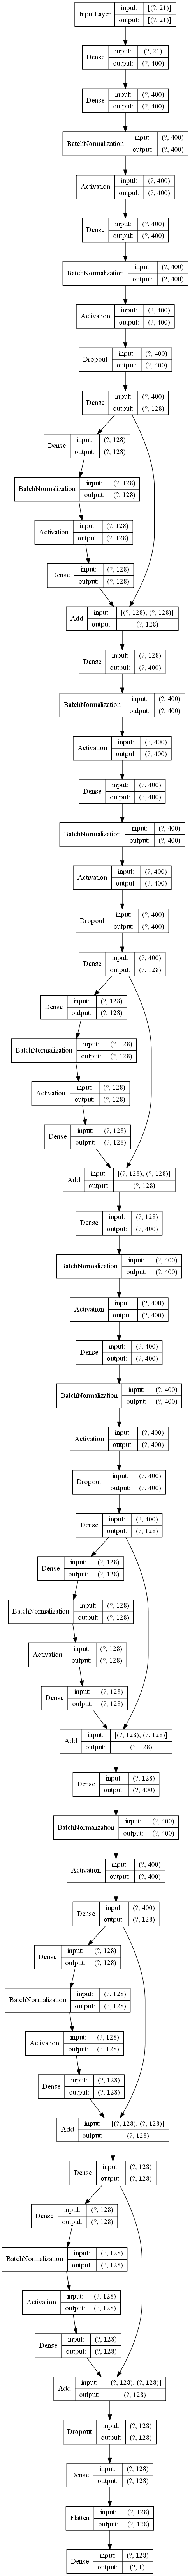

In [104]:
# plotting the neural network architecture
plot_model(final_model, show_shapes=True, show_layer_names=False)

In [105]:
# training the model
history = final_model.fit(x = X_train, y = y_train, validation_data=(X_val, y_val),
                epochs=epochs, batch_size= batch_size, verbose= 1)

Epoch 1/80
69/69 [==============================] - 2s 27ms/step - loss: 0.8155 - accuracy: 0.7453 - val_loss: 0.7159 - val_accuracy: 0.7893
Epoch 2/80
69/69 [==============================] - 1s 19ms/step - loss: 0.7290 - accuracy: 0.7680 - val_loss: 0.6622 - val_accuracy: 0.8063
Epoch 3/80
69/69 [==============================] - 1s 19ms/step - loss: 0.6843 - accuracy: 0.7871 - val_loss: 0.6485 - val_accuracy: 0.8166
Epoch 4/80
69/69 [==============================] - 1s 18ms/step - loss: 0.6416 - accuracy: 0.8099 - val_loss: 0.5967 - val_accuracy: 0.8277
Epoch 5/80
69/69 [==============================] - 1s 19ms/step - loss: 0.6043 - accuracy: 0.8226 - val_loss: 0.5534 - val_accuracy: 0.8373
Epoch 6/80
69/69 [==============================] - 1s 18ms/step - loss: 0.5709 - accuracy: 0.8268 - val_loss: 0.5393 - val_accuracy: 0.8301
Epoch 7/80
69/69 [==============================] - 1s 18ms/step - loss: 0.5426 - accuracy: 0.8324 - val_loss: 0.5154 - val_accuracy: 0.8383
Epoch 8/80
69

Epoch 59/80
69/69 [==============================] - 2s 29ms/step - loss: 0.3246 - accuracy: 0.8481 - val_loss: 0.3278 - val_accuracy: 0.8481
Epoch 60/80
69/69 [==============================] - 4s 56ms/step - loss: 0.3244 - accuracy: 0.8500 - val_loss: 0.3411 - val_accuracy: 0.8497
Epoch 61/80
69/69 [==============================] - 6s 92ms/step - loss: 0.3223 - accuracy: 0.8491 - val_loss: 0.3297 - val_accuracy: 0.8494
Epoch 62/80
69/69 [==============================] - 5s 79ms/step - loss: 0.3211 - accuracy: 0.8494 - val_loss: 0.3278 - val_accuracy: 0.8564
Epoch 63/80
69/69 [==============================] - 2s 26ms/step - loss: 0.3241 - accuracy: 0.8480 - val_loss: 0.3312 - val_accuracy: 0.8492
Epoch 64/80
69/69 [==============================] - 4s 52ms/step - loss: 0.3243 - accuracy: 0.8490 - val_loss: 0.3365 - val_accuracy: 0.8489
Epoch 65/80
69/69 [==============================] - 4s 56ms/step - loss: 0.3207 - accuracy: 0.8482 - val_loss: 0.3391 - val_accuracy: 0.8533
Epoch 

In [106]:
# evaluating the model
final_score = final_model.evaluate(X_test, y_test, verbose=1)

for i in range(len(final_score)):
    print("Test " + final_model.metrics_names[i] + " = %.3f" % final_score[i])
    
print('\n')    
y_preds = final_model.predict(X_test)
y_preds = np.round(y_preds)

y_preds.shape

y_preds = y_preds.reshape(y_preds.shape[0],)

np.unique(y_preds)

np.unique(y_test)

# Making confusion matrix
confusion_matrix(y_test, y_preds)

# priniting classification report 
print(classification_report(y_test, y_preds, target_names=['class 0', 'class 1']))

114/114 [==============================] - 1s 5ms/step - loss: 0.3634 - accuracy: 0.8537
Test loss = 0.363
Test accuracy = 0.854


              precision    recall  f1-score   support

     class 0       0.72      0.51      0.60       779
     class 1       0.88      0.95      0.91      2865

    accuracy                           0.85      3644
   macro avg       0.80      0.73      0.76      3644
weighted avg       0.84      0.85      0.84      3644



In [107]:
from utils import PlotModelEval

In [108]:
import itertools
def PlotConfusionMatrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues,
                        showAcc=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            verticalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if showAcc:
        acc = 100*(np.trace(cm) / np.sum(cm))
        title = title + " | Acc=%.2f%%" % acc
        
    plt.title(title)
    
    
    
def PlotModelEval(Model, History, X, Y, Labels):
    
    # Scores for each class (can be interpreted as probabilities since we use softmax output)
    S = Model.predict(X)
    # Prediction (class number) for each test image
    P = y_preds
    # Calculate confusion matrix
    CM = confusion_matrix(Y,P)
    
    # Plot training history
    plt.figure(figsize=(16,6))
    plt.subplot(2,2,1)
    plt.semilogy(History.history['loss'], label="Training")
    if 'val_loss' in History.history:
        plt.semilogy(History.history['val_loss'], label="Validation")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True, which="both")
    plt.subplot(2,2,3)
    plt.plot(100 * np.array(History.history['accuracy']), label="Training")
    if 'val_accuracy' in History.history:
        plt.plot(100 * np.array(History.history['val_accuracy']), label="Validation")
    plt.title('Model accuracy')
    plt.ylabel('Acc [%]')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True, which="both")
    
    # Plot confusion matrix
    plt.subplot(2,2,(2,4))
    PlotConfusionMatrix(CM, classes=Labels, title="Confusion matrix (test)")
    plt.show()

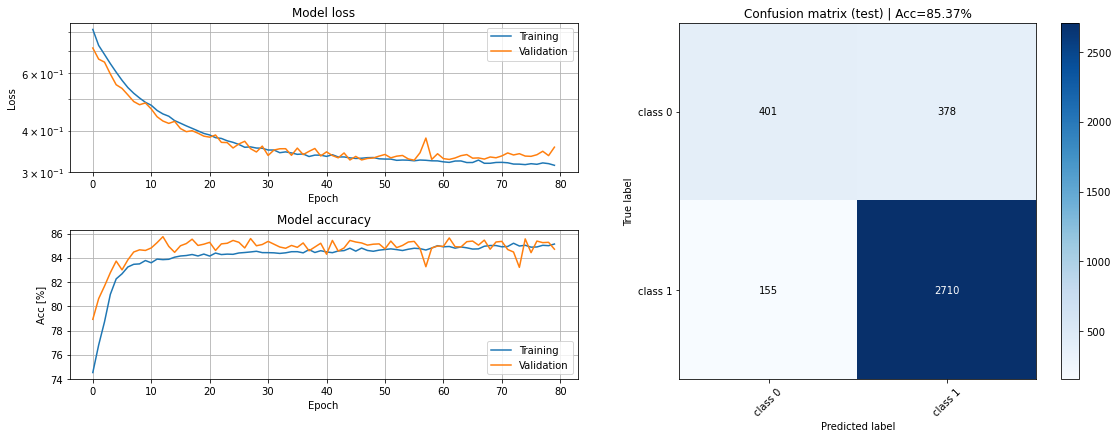

In [109]:
# Custom function for evaluating the model and plotting training history
PlotModelEval(final_model, history, X_test, y_test, ['class 0', 'class 1'])

# We are going to create an OPTUNA objective function of an ensemble of classifiers using voting classifier from intel extension of scikit-learn and optimize the hyper parameter space

In [101]:
# Objective function for Optuna
def objective(trial):
    
    
    
    ####################################################
    #logistic regression
    lr_penalty = trial.suggest_categorical('lr_penalty', ['l1', 'l2', 'elasticnet'])
    
    # L1 penalty ratios
    lr_l1_ratio = None
    
    if lr_penalty == 'l1':
        lr_solver = trial.suggest_categorical('lr_solver1', ['liblinear', 'saga'])
    elif lr_penalty == 'l2':
        lr_solver = trial.suggest_categorical('lr_solver2', ['newton-cg', 'lbfgs', 'sag', 'liblinear', 'saga'])
    else:
        lr_solver = 'saga'
        lr_l1_ratio = trial.suggest_uniform('lr_l1_ratio', 0.0, 1.0)
    
    # Tolerance trails for Logistic regression
    lr_tol = trial.suggest_uniform('lr_tol', 1e-5, 1e-2)
    # Trials for C values
    lr_C = trial.suggest_uniform('lr_C', 0.0, 1.0)
    
    # Logistic regression model with all trials embedded
    lr = LogisticRegression(C=lr_C, penalty=lr_penalty, tol=lr_tol, solver=lr_solver, l1_ratio=lr_l1_ratio)
    

    
    
    #####################################################
    #KNN
    
    # Trials for number of neighbors
    knn_neighbors = trial.suggest_int('knn_neighbors', 2, 100)
    # Trials for weights of samples
    knn_weights = trial.suggest_categorical('knn_weights', ['uniform', 'distance'])
    # Trials for probability
    knn_p = trial.suggest_categorical('knn_p', [1, 2])
    
    # KNN model with all trials embedded
    knn = KNeighborsClassifier(n_neighbors=knn_neighbors, weights=knn_weights, p=knn_p)
   



    ######################################################
    #SVM
    
    # Trials for C values
    svm_C = trial.suggest_uniform('svm_C', 0.0, 1.0)
    # Trials for different kernels
    svm_kernel = trial.suggest_categorical('svm_kernel', ['poly', 'rbf'])
    # polynomial degree is fixed
    svm_degree = 3
    if svm_kernel == 'poly':
        svm_degree = trial.suggest_int('svm_degree', 1, 10)
    svm_tol = trial.suggest_uniform('svm_tol', 1e-5, 1e-2)
    
    # Support Vector Machine model with all trials embedded
    svm = SVC(C=svm_C, kernel=svm_kernel, degree=svm_degree, tol=svm_tol)
    
    
    
    ######################################################
    # Random Forests
    
    # Trials for number of estimators
    rf_estimators = trial.suggest_int('rf_estimators', 1, 500)
    # Trials for splitting criterion
    rf_criterion = trial.suggest_categorical('rf_criterion', ['entropy', 'gini'])
    # Trials for max depth of decision tree
    rf_max_depth = trial.suggest_int('rf_max_depth', 1, 100)
    # Trials for minimum split leaves
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 50)
    # Trials for sample leaves
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 25)
    
    # Random Forests model with all trials embedded
    rf = RandomForestClassifier(n_estimators=rf_estimators, criterion=rf_criterion, max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split, min_samples_leaf=rf_min_samples_leaf)
    

 
    ######################################################

    # Ensemble Model
    logr_w = trial.suggest_uniform('logr_w', 0.0, 1.0)
    knn_w = trial.suggest_uniform('knn_w', 0.0, 1.0)
    svm_w = trial.suggest_uniform('svm_w', 0.0, 1.0)
    rf_w = trial.suggest_uniform('rf_w', 0.0, 1.0)
    

    
    ensemble_voting = VotingClassifier(estimators=[
        ('lr', lr),
        ('knn', knn),
        ('svm', svm),
        ('rf', rf)], weights=[logr_w, knn_w, svm_w, rf_w])

    ensemble_voting.fit(X_train, y_train)
    preds = ensemble_voting.predict(X_val)
    
    acc = accuracy_score(y_val, preds)

    return acc

In [104]:
#optuna.logging.set_verbosity(optuna.logging.ERROR)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-14 15:54:23,294] A new study created in memory with name: no-name-58cfebbd-c70c-4806-89b9-a4e31e906429
[I 2022-05-14 15:54:49,939] Trial 0 finished with value: 0.7897727272727273 and parameters: {'lr_penalty': 'l1', 'lr_solver1': 'saga', 'lr_tol': 0.003567286494008915, 'lr_C': 0.9167233678431944, 'knn_neighbors': 60, 'knn_weights': 'uniform', 'knn_p': 2, 'svm_C': 0.5326451689436209, 'svm_kernel': 'poly', 'svm_degree': 1, 'svm_tol': 0.009957095424508034, 'rf_estimators': 169, 'rf_criterion': 'entropy', 'rf_max_depth': 36, 'rf_min_samples_split': 25, 'rf_min_samples_leaf': 11, 'lr_w': 0.07044474689502711, 'knn_w': 0.06637853001883998, 'svm_w': 0.508432933532857, 'rf_w': 0.11003650209281757}. Best is trial 0 with value: 0.7897727272727273.
D:\Softwares\Anaconda_Navigator\envs\gpu_cuda\lib\site-packages\daal4py\sklearn\neighbors\_base.py:361: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exampl

D:\Softwares\Anaconda_Navigator\envs\gpu_cuda\lib\site-packages\daal4py\sklearn\neighbors\_base.py:361: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
D:\Softwares\Anaconda_Navigator\envs\gpu_cuda\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
[I 2022-05-14 16:11:37,248] Trial 9 finished with value: 0.7910640495867769 and parameters: {'lr_penalty': 'elasticnet', 'lr_l1_ratio': 0.37442758874199467, 'lr_tol': 0.009109050518599887, 'lr_C': 0.08237638246015566, 'knn_neighbors': 2, 'knn_weights': 'distance', 'knn_p': 1, 'svm_C': 0.288256379891202, 'svm_kernel': 'poly', 'svm_degree': 2, 'svm_tol': 0.0024737082732105577, 'rf_estimators': 463, 'rf_criterion': 'gini', 'rf_max_depth': 

D:\Softwares\Anaconda_Navigator\envs\gpu_cuda\lib\site-packages\daal4py\sklearn\neighbors\_base.py:361: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
D:\Softwares\Anaconda_Navigator\envs\gpu_cuda\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
[I 2022-05-14 16:15:37,915] Trial 16 finished with value: 0.8285123966942148 and parameters: {'lr_penalty': 'elasticnet', 'lr_l1_ratio': 0.01817770161482032, 'lr_tol': 0.00161643477856258, 'lr_C': 0.4094536424113282, 'knn_neighbors': 36, 'knn_weights': 'uniform', 'knn_p': 1, 'svm_C': 0.005492903417763432, 'svm_kernel': 'rbf', 'svm_tol': 0.008140958891669088, 'rf_estimators': 142, 'rf_criterion': 'entropy', 'rf_max_depth': 80, 'rf_min_sa

[I 2022-05-14 16:21:45,115] Trial 27 finished with value: 0.8137913223140496 and parameters: {'lr_penalty': 'l2', 'lr_solver2': 'liblinear', 'lr_tol': 0.0029963285789717177, 'lr_C': 0.6321731624291336, 'knn_neighbors': 33, 'knn_weights': 'uniform', 'knn_p': 2, 'svm_C': 0.3847037444609689, 'svm_kernel': 'rbf', 'svm_tol': 0.007512434920516663, 'rf_estimators': 116, 'rf_criterion': 'entropy', 'rf_max_depth': 84, 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 24, 'lr_w': 0.7768951231302107, 'knn_w': 0.6219131501166636, 'svm_w': 0.27071648430247325, 'rf_w': 0.9079639145896201}. Best is trial 21 with value: 0.8416838842975206.
[I 2022-05-14 16:22:30,866] Trial 28 finished with value: 0.8109504132231405 and parameters: {'lr_penalty': 'l2', 'lr_solver2': 'saga', 'lr_tol': 0.0021416157598544783, 'lr_C': 0.48502893092489746, 'knn_neighbors': 96, 'knn_weights': 'uniform', 'knn_p': 2, 'svm_C': 0.4477370524330059, 'svm_kernel': 'rbf', 'svm_tol': 0.0032371879021604773, 'rf_estimators': 277, 'rf_c

D:\Softwares\Anaconda_Navigator\envs\gpu_cuda\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
[I 2022-05-14 16:27:55,574] Trial 36 finished with value: 0.8210227272727273 and parameters: {'lr_penalty': 'l1', 'lr_solver1': 'liblinear', 'lr_tol': 0.0031213025841279607, 'lr_C': 0.34667484631797457, 'knn_neighbors': 78, 'knn_weights': 'uniform', 'knn_p': 1, 'svm_C': 0.19646078147090124, 'svm_kernel': 'poly', 'svm_degree': 6, 'svm_tol': 0.004341122267362057, 'rf_estimators': 119, 'rf_criterion': 'entropy', 'rf_max_depth': 69, 'rf_min_samples_split': 17, 'rf_min_samples_leaf': 23, 'lr_w': 0.7385781228037094, 'knn_w': 0.9383617343432505, 'svm_w': 0.6639853852705502, 'rf_w': 0.8220731808631994}. Best is trial 21 with value: 0.8416838842975206.
[I 2022-05-14 16:28:10,474] Trial 37 finished with value: 0.8158574380165289 and parameters: {'l

D:\Softwares\Anaconda_Navigator\envs\gpu_cuda\lib\site-packages\daal4py\sklearn\neighbors\_base.py:361: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
D:\Softwares\Anaconda_Navigator\envs\gpu_cuda\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
[I 2022-05-14 16:50:43,162] Trial 44 finished with value: 0.7995867768595041 and parameters: {'lr_penalty': 'l1', 'lr_solver1': 'saga', 'lr_tol': 0.004045241440658476, 'lr_C': 0.9062355464696908, 'knn_neighbors': 14, 'knn_weights': 'distance', 'knn_p': 1, 'svm_C': 0.21163144436671055, 'svm_kernel': 'poly', 'svm_degree': 8, 'svm_tol': 0.001643167050437789, 'rf_estimators': 37, 'rf_criterion': 'gini', 'rf_max_depth': 34, 'rf_min_samples_s

D:\Softwares\Anaconda_Navigator\envs\gpu_cuda\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
[I 2022-05-14 17:07:04,819] Trial 51 finished with value: 0.837551652892562 and parameters: {'lr_penalty': 'l1', 'lr_solver1': 'saga', 'lr_tol': 0.0035343445646451375, 'lr_C': 0.9311230438274652, 'knn_neighbors': 6, 'knn_weights': 'distance', 'knn_p': 1, 'svm_C': 0.11649946123524271, 'svm_kernel': 'poly', 'svm_degree': 7, 'svm_tol': 0.007067305986682116, 'rf_estimators': 100, 'rf_criterion': 'entropy', 'rf_max_depth': 23, 'rf_min_samples_split': 23, 'rf_min_samples_leaf': 21, 'lr_w': 0.9226940295783366, 'knn_w': 0.9378705499400259, 'svm_w': 0.5314762167807187, 'rf_w': 0.9407101454983751}. Best is trial 21 with value: 0.8416838842975206.
D:\Softwares\Anaconda_Navigator\envs\gpu_cuda\lib\site-packages\daal4py\sklearn\neighbors\_base.py:361:

[I 2022-05-14 17:27:43,651] Trial 58 finished with value: 0.8336776859504132 and parameters: {'lr_penalty': 'l1', 'lr_solver1': 'saga', 'lr_tol': 0.0028210915696063165, 'lr_C': 0.7670379729015372, 'knn_neighbors': 11, 'knn_weights': 'distance', 'knn_p': 1, 'svm_C': 0.27402541980447537, 'svm_kernel': 'poly', 'svm_degree': 7, 'svm_tol': 0.009437005371652318, 'rf_estimators': 106, 'rf_criterion': 'gini', 'rf_max_depth': 10, 'rf_min_samples_split': 23, 'rf_min_samples_leaf': 22, 'lr_w': 0.8087174610312127, 'knn_w': 0.9938261198653964, 'svm_w': 0.502358923493978, 'rf_w': 0.8413276251320889}. Best is trial 21 with value: 0.8416838842975206.
D:\Softwares\Anaconda_Navigator\envs\gpu_cuda\lib\site-packages\daal4py\sklearn\neighbors\_base.py:361: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
D:\Softwares\Anaconda_Navigator\envs\gpu_cuda\lib

[I 2022-05-14 17:35:13,806] Trial 66 finished with value: 0.8535640495867769 and parameters: {'lr_penalty': 'elasticnet', 'lr_l1_ratio': 0.31512974406971606, 'lr_tol': 0.0020322095959224816, 'lr_C': 0.8538732087250642, 'knn_neighbors': 9, 'knn_weights': 'uniform', 'knn_p': 2, 'svm_C': 0.6592655251892485, 'svm_kernel': 'rbf', 'svm_tol': 0.007716408536514767, 'rf_estimators': 200, 'rf_criterion': 'entropy', 'rf_max_depth': 42, 'rf_min_samples_split': 19, 'rf_min_samples_leaf': 20, 'lr_w': 0.0046300312907135745, 'knn_w': 0.48787144086979684, 'svm_w': 0.04238363772355462, 'rf_w': 0.9621926383540154}. Best is trial 66 with value: 0.8535640495867769.
[I 2022-05-14 17:35:57,010] Trial 67 finished with value: 0.8589876033057852 and parameters: {'lr_penalty': 'elasticnet', 'lr_l1_ratio': 0.1282055016575825, 'lr_tol': 0.0013540177000631328, 'lr_C': 0.7359590704902361, 'knn_neighbors': 10, 'knn_weights': 'uniform', 'knn_p': 2, 'svm_C': 0.3682871921530707, 'svm_kernel': 'rbf', 'svm_tol': 0.0077398

[I 2022-05-14 17:45:37,254] Trial 79 finished with value: 0.859245867768595 and parameters: {'lr_penalty': 'elasticnet', 'lr_l1_ratio': 0.08051122462403681, 'lr_tol': 0.00086119797581881, 'lr_C': 0.5907460036282914, 'knn_neighbors': 39, 'knn_weights': 'uniform', 'knn_p': 2, 'svm_C': 0.8161966604064729, 'svm_kernel': 'rbf', 'svm_tol': 0.009661172784223775, 'rf_estimators': 307, 'rf_criterion': 'gini', 'rf_max_depth': 44, 'rf_min_samples_split': 15, 'rf_min_samples_leaf': 2, 'lr_w': 0.10609375779544322, 'knn_w': 0.436007038510282, 'svm_w': 0.003814211512700276, 'rf_w': 0.5486870830957744}. Best is trial 75 with value: 0.8600206611570248.
[I 2022-05-14 17:46:03,131] Trial 80 finished with value: 0.8220557851239669 and parameters: {'lr_penalty': 'elasticnet', 'lr_l1_ratio': 0.06863299151479482, 'lr_tol': 0.0009142123185110503, 'lr_C': 0.596361505287186, 'knn_neighbors': 40, 'knn_weights': 'uniform', 'knn_p': 2, 'svm_C': 0.8701686398444066, 'svm_kernel': 'rbf', 'svm_tol': 0.0096573042575274

[I 2022-05-14 17:51:19,314] Trial 92 finished with value: 0.8548553719008265 and parameters: {'lr_penalty': 'elasticnet', 'lr_l1_ratio': 0.057985595772461776, 'lr_tol': 0.001147449328684644, 'lr_C': 0.5220524459755935, 'knn_neighbors': 54, 'knn_weights': 'uniform', 'knn_p': 2, 'svm_C': 0.7302404983827065, 'svm_kernel': 'rbf', 'svm_tol': 0.008690747298967651, 'rf_estimators': 283, 'rf_criterion': 'gini', 'rf_max_depth': 54, 'rf_min_samples_split': 17, 'rf_min_samples_leaf': 3, 'lr_w': 0.1759427554979172, 'knn_w': 0.38279272104662027, 'svm_w': 0.02368298663644921, 'rf_w': 0.6605369636207494}. Best is trial 75 with value: 0.8600206611570248.
[I 2022-05-14 17:51:48,330] Trial 93 finished with value: 0.8579545454545454 and parameters: {'lr_penalty': 'elasticnet', 'lr_l1_ratio': 0.16882019428998324, 'lr_tol': 0.00028457535726329156, 'lr_C': 0.5016655108023627, 'knn_neighbors': 42, 'knn_weights': 'uniform', 'knn_p': 2, 'svm_C': 0.899436417745369, 'svm_kernel': 'rbf', 'svm_tol': 0.009754078338

In [105]:
study.best_params

{'lr_penalty': 'elasticnet',
 'lr_l1_ratio': 0.2112744795805186,
 'lr_tol': 0.0007835048639900213,
 'lr_C': 0.623510727584215,
 'knn_neighbors': 26,
 'knn_weights': 'uniform',
 'knn_p': 2,
 'svm_C': 0.6301532188169567,
 'svm_kernel': 'rbf',
 'svm_tol': 0.009091792023585859,
 'rf_estimators': 299,
 'rf_criterion': 'gini',
 'rf_max_depth': 30,
 'rf_min_samples_split': 10,
 'rf_min_samples_leaf': 1,
 'lr_w': 0.10913043839614027,
 'knn_w': 0.4166692113067154,
 'svm_w': 0.025464590107005435,
 'rf_w': 0.6958783869393963}

### Now we can create a model based on best hyper parameters and evaluate it on testing data

In [107]:
def create_ensemble_model(params_best):
    
    ########################################## K-Nearest Neighbor Classifier ################################
    
    
    knn = KNeighborsClassifier(
        n_neighbors= params_best['knn_neighbors'], 
        weights=params_best['knn_weights'], 
        p = params_best['knn_p']
    )
    
    
    
    ############################################# Logistic Regression ######################################
    
    
    
    logr = LogisticRegression(
        penalty=params_best['lr_penalty'],
        tol = params_best['lr_tol'],
        l1_ratio=params_best['lr_l1_ratio'],
        C = params_best['lr_C'],
        solver='saga'
    )
    
    
    ############################################# Support Vector Machines ###################################
    
    
    svc = SVC(C= params_best['svm_C'],
             kernel=params_best['svm_kernel'],
             tol=params_best['svm_tol'],
             degree=4
             
             )
    
    
    ############################################### Random Forests ##########################################
    
    
    rf = RandomForestClassifier(n_estimators=params_best['rf_estimators'],
                               criterion=params_best['rf_criterion'],
                               max_depth=params_best['rf_max_depth'],
                               min_samples_split=params_best['rf_min_samples_split'],
                               min_samples_leaf=params_best['rf_min_samples_leaf'])
    
    
    
    ensemble_voting = VotingClassifier(estimators=[
         
                    ('logr', logr),
                    ('knn', knn),
                    ('svc', svc),
                    ('rf', rf)],
                    weights=[
                    params_best['lr_w'],
                    params_best['knn_w'],
                    params_best['svm_w'],
                    params_best['rf_w']]
                         )

    ensemble_voting.fit(X_train, y_train)
    
    return ensemble_voting
    

In [109]:
final_ensemble_model = create_ensemble_model(study.best_params)

In [116]:
#creates shap explainer
explainer = shap.Explainer(final_ensemble_model.predict, X_train, feature_names=X_train.columns.tolist())
shap_values = explainer(X_test)

Permutation explainer: 3645it [4:50:22,  4.78s/it]                                                                     


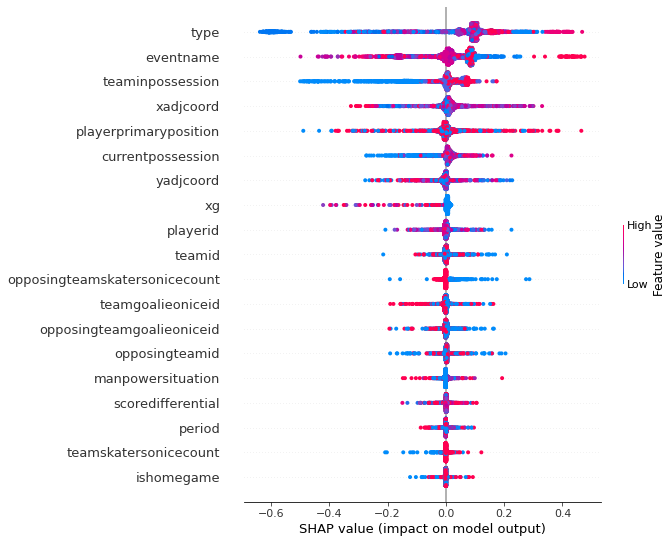

In [134]:
#plots importance of each feature
shap.summary_plot(shap_values, X_test)

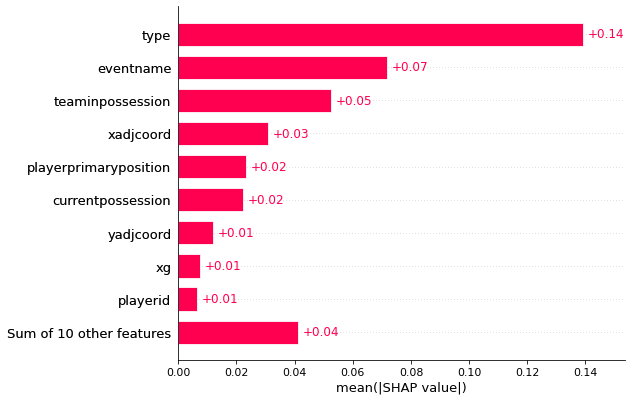

In [137]:
# We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot
shap.plots.bar(shap_values)

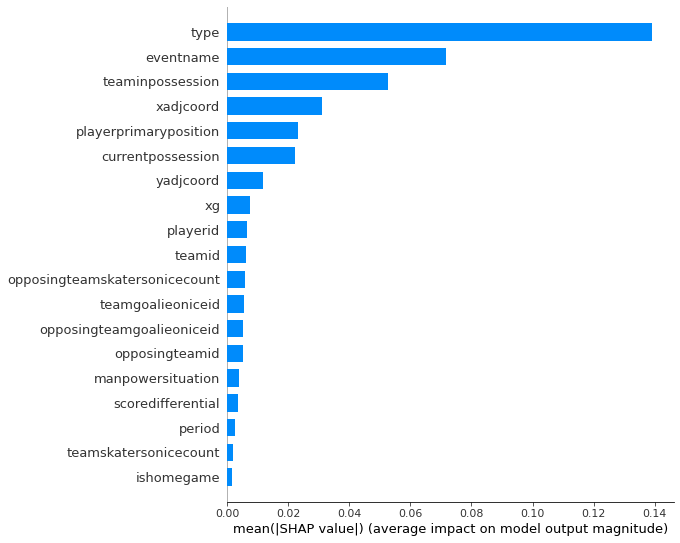

In [138]:
#plots importance of each feature
shap.summary_plot(shap_values, X_test, plot_type="bar")

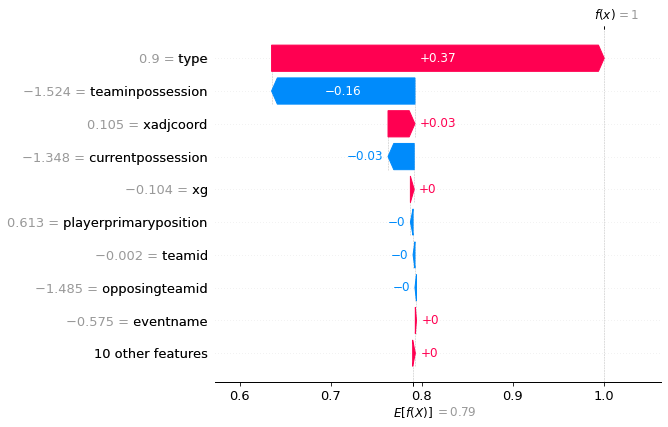

In [139]:
# The above explanation shows features each contributing to push the model output from the base value 
# (the average model output over the training dataset we passed) to the model output. Features pushing the 
# prediction higher are shown in red, those pushing the prediction lower are in blue.
shap.plots.waterfall(shap_values[0])

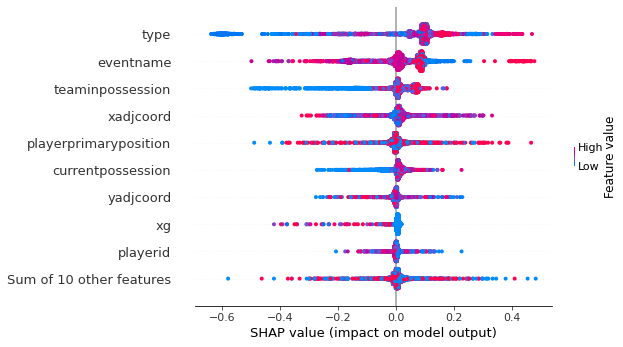

In [140]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

In [141]:
#displays the final evaluation
y_preds = final_ensemble_model.predict(X_test)
print('Test Accuracy:', round(accuracy_score(y_test, y_preds), 2))

Test Accuracy: 0.87


# THANKS!